In [1]:
# Notebook / Runpod setup, safe to ignore
%pip install python-dotenv anthropic matplotlib accelerate datasets einops huggingface-hub jaxtyping natsort simple-parsing triton transformers gguf sentencepiece scikit-learn seaborn umap-learn
%pip install -U safetensors>=0.4.3
%pip install git+https://github.com/EleutherAI/sae.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.1/165.1 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 65.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 44.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 47.8 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of fsspec[http] to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.2/69.2 kB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 120.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 171.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.4/336.4 kB 155.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys, os
from dotenv import load_dotenv


sys.path.insert(0, "/workspace/experiments")
os.environ["HF_HOME"] = "/workspace/experiments/hf"

# Load environment variables from .env file
load_dotenv()

True

In [4]:
from huggingface_hub import notebook_login
notebook_login()

In [5]:
import json

import tqdm
import torch
import numpy as np

from repeng import ControlVector, ControlModel, DatasetEntry
import repeng.saes

import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from collections import Counter
import math

import anthropic
import json
import pickle

from typing import Union, List, Dict
from anthropic.types.beta.message_create_params import MessageCreateParamsNonStreaming
from anthropic.types.beta.messages.batch_create_params import Request

In [6]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import gc
torch.cuda.empty_cache()

# Collect garbage
gc.collect()

# Force CUDA to sync
torch.cuda.synchronize()

tokenizer = AutoTokenizer.from_pretrained("meta-llama/Meta-Llama-3-8B")
tokenizer.pad_token_id = tokenizer.eos_token_id

control_layers = list(range(1, 31))

In [7]:
base_model = AutoModelForCausalLM.from_pretrained(
    "meta-llama/Meta-Llama-3-8B",
    torch_dtype="auto").to(
    torch.device("cuda:0"))
base_model = ControlModel(base_model, control_layers)

instruct_model = AutoModelForCausalLM.from_pretrained(
    "meta-llama/Meta-Llama-3-8B-Instruct",
    torch_dtype="auto").to(
    torch.device("cuda:0"))
instruct_model = ControlModel(instruct_model, control_layers)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [8]:
#sae_labeled = repeng.saes.from_eleuther(device="cuda:0", layers=[24, 30], repo='EleutherAI/sae-llama-3.1-8b-64x', revision='cca69a815bf3e8ce60f3ed19d197cd6e4e3662cc')
sae_full = repeng.saes.from_eleuther(device="cuda:1", layers=control_layers)

Fetching 66 files:   0%|          | 0/66 [00:00<?, ?it/s]

100%|██████████| 30/30 [02:31<00:00,  5.05s/it]


In [9]:
# repeng dataloading / template boilerplate
with open("/workspace/experiments/notebooks/data/all_truncated_outputs.json") as f:
    output_suffixes = json.load(f)
truncated_output_suffixes = [
    tokenizer.convert_tokens_to_string(tokens[:i])
    for tokens in (tokenizer.tokenize(s) for s in output_suffixes)
    for i in range(1, len(tokens))
]
truncated_output_suffixes_512 = [
    tokenizer.convert_tokens_to_string(tokens[:i])
    for tokens in (tokenizer.tokenize(s) for s in output_suffixes[:512])
    for i in range(1, len(tokens))
]

with open("/workspace/experiments/notebooks/data/true_facts.json") as f:
    fact_suffixes = json.load(f)
truncated_fact_suffixes = [
    tokenizer.convert_tokens_to_string(tokens[:i])
    for tokens in (tokenizer.tokenize(s) for s in fact_suffixes)
    for i in range(1, len(tokens) - 5)
]

# base model so roll our own instruct template
# TEMPLATE = """{persona} is talking to the user.

# User: {user_msg}

# AI: {prefill}"""
# TEMPLATE = """<|start_header_id|>system<|end_header_id|>
# {persona} is talking to the user.<|eot_id|><|start_header_id|>user<|end_header_id|>

# {user_msg}<|eot_id|><|start_header_id|>assistant<|end_header_id|>

# {prefill}"""
TEMPLATE = """{persona}. {prefill}"""

def template_parse(resp: str) -> tuple[str, str, str]:
    if "<|start_header_id|>user" in resp:
        persona = ""
        _, rest = resp.split("<|start_header_id|>user<|end_header_id|>")
        user, assistant = rest.split("<|eot_id|><|start_header_id|>assistant<|end_header_id|>")
    elif "User:" in resp:
        persona, rest = resp.split("\n\nUser: ", 1)
        user, assistant = rest.split("\n\nAI: ", 1)
    else:
        persona = ""
        user = ""
        assistant = resp

    return (persona.strip(), user.strip(), assistant.strip())

def make_dataset(
    persona_template: str,
    positive_personas: list[str],
    negative_personas: list[str],
    user_msg: str,
    suffix_list: list[str]
) -> list[DatasetEntry]:
    dataset = []
    for suffix in suffix_list:
        for positive_persona, negative_persona in zip(positive_personas, negative_personas):
            pos = persona_template.format(persona=positive_persona)
            neg = persona_template.format(persona=negative_persona)
            dataset.append(
                DatasetEntry(
                    positive=TEMPLATE.format(persona=pos, user_msg=user_msg, prefill=suffix),
                    negative=TEMPLATE.format(persona=neg, user_msg=user_msg, prefill=suffix),
                )
            )
    return dataset

from IPython.display import display, HTML
from transformers import TextStreamer

class HTMLStreamer(TextStreamer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.display_handle = display(display_id=True)
        self.full_text = ""

    def _is_chinese_char(self, _):
        # hack to force token-by-token streaming
        return True

    def on_finalized_text(self, text: str, stream_end: bool = False):
        self.full_text += text
        persona, user, assistant = template_parse(self.full_text)
        html = HTML(f"""
        <div style='border: 1px solid black; border-radius: 5px; margin-bottom: 5px; padding: 5px;'>
            <strong>persona</strong>
            <p>{persona}</p>
            <strong>user</strong>
            <p>{user}</p>
            <strong>assistant</strong>
            <p>{assistant}</p>
        </div>
        """)
        self.display_handle.update(html)

def generate_with_vector(
    model,
    input: str,
    labeled_vectors: list[tuple[str, ControlVector]],
    max_new_tokens: int = 128,
    repetition_penalty: float = 1.1,
    show_baseline: bool = False,
    temperature: float = 0.7,
):
    input_ids = tokenizer(input, return_tensors="pt").to(model.device)
    settings = {
        "pad_token_id": tokenizer.eos_token_id, # silence warning
        #"do_sample": False, # temperature=0
        "temperature": temperature,
        "max_new_tokens": max_new_tokens,
        "repetition_penalty": repetition_penalty,
    }

    def gen(label):
        display(HTML(f"<h3>{label}</h3>"))
        output = model.generate(streamer=HTMLStreamer(tokenizer), **input_ids, **settings)
        generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
        # perplexity = calculate_perplexity(model, tokenizer, generated_text)
        # display(HTML(f"<p>Perplexity: {perplexity:.2f}</p>"))
        print(generated_text)

    if show_baseline:
        model.reset()
        gen("baseline")
    for label, vector in labeled_vectors:
        model.set_control(vector)
        gen(label)
    model.reset()

In [10]:
def visualize_discontinuities(x, y, discontinuities):
    """
    Visualize the detected discontinuities on the original data.
    """
    plt.figure(figsize=(12, 6))
    # Change from line plot to scatter plot
    plt.scatter(x, y, c='b', s=20, alpha=0.6, label='Original data')
    
    x_discontinuities = x[discontinuities]
    y_discontinuities = y[discontinuities]

    plt.scatter(x_discontinuities, y_discontinuities, c='r', s=100, 
               label='Detected discontinuities', zorder=3)
    
    # Add vertical lines at discontinuities
    for idx in discontinuities:
        plt.axvline(x=x[idx], color='r', linestyle='--', alpha=0.3)
    
    plt.legend()
    plt.grid(True)
    plt.title('Detected Discontinuities')
    plt.show()

def find_significant_drop(x, y, drop_threshold=0.10, window_size=1):
    """
    Find the first point where perplexity drops significantly below starting value.
    
    Parameters:
    x: array-like, coefficients
    y: array-like, perplexity values
    drop_threshold: float, minimum drop as fraction of starting value (default 0.2 = 20%)
    window_size: int, number of consecutive points to check to avoid noise (default 3)
    
    Returns:
    tuple: (x value where drop occurs, index of drop point)
    """
    # Get baseline from start of sequence
    baseline = y[0]
    target_value = baseline * (1 + drop_threshold)
    
    # Look for first window where all values are below target
    for i in range(len(y) - window_size + 1):
        window = y[i:i+window_size]
        if all([val < target_value for val in window]):
            return i
            
    # If no significant drop found
    return None

def calculate_entropy(model, sequence):
    tokens = sequence.tolist()
    token_counts = Counter(tokens)
    total_tokens = len(tokens)
    probabilities = [count / total_tokens for count in token_counts.values()]
    entropy = -sum(p * math.log2(p) for p in probabilities if p > 0)
    max_entropy = math.log2(len(token_counts))
    normalized_entropy = entropy / max_entropy if max_entropy > 0 else 0
    return normalized_entropy

def calculate_perplexity_with_entropy(model, sequence, beta=10):
    perplexity = calculate_perplexity(model, sequence)
    norm_entropy = calculate_entropy(model, sequence)
    adjusted_perplexity = perplexity * (1 + beta * ((1 - norm_entropy)**2))
    return adjusted_perplexity

def calculate_repetition_score(model, sequence):
    """
    Calculate a repetition score based on repeated token sequences.
    Returns a value between 0 and 1, where higher values indicate more repetition.
    """
    tokens = sequence.tolist()
    if len(tokens) <= 1:
        return 0
    
    # Look for repeating sequences of 2-4 tokens
    ngram_scores = []
    for n in range(2, 5):
        if len(tokens) > n:
            # Create n-grams
            ngrams = [tuple(tokens[i:i+n]) for i in range(len(tokens)-n+1)]
            # Count repetitions
            ngram_counts = Counter(ngrams)
            # Calculate score for this n-gram size
            score = sum(c - 1 for c in ngram_counts.values()) / max(len(ngrams), 1)
            ngram_scores.append(score)
    
    # Weight longer sequences more heavily
    if ngram_scores:
        weights = [1, 2, 3]  # More weight to longer sequences
        repetition_score = sum(s * w for s, w in zip(ngram_scores, weights)) / sum(weights)
        return min(repetition_score, 1.0)
    return 0.0

def calculate_perplexity_with_repetition_bias(model, sequence, beta=10):
    """
    Adjust perplexity based on repetition in the token sequence.
    Higher repetition leads to higher adjusted perplexity.
    """
    perplexity = calculate_perplexity(model, sequence)
    repetition_score = calculate_repetition_score(model, sequence)
    adjusted_perplexity = perplexity * (1 + beta * (repetition_score**2))
    return adjusted_perplexity

def calculate_perplexity(model, sequence):
    input_ids = sequence.unsqueeze(0)
    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
        loss = outputs.loss
        perplexity = torch.exp(loss).item()
    return perplexity

def cross_entropy_loss(model, sequence):
    input_ids = sequence.unsqueeze(0)
    
    # Create targets by shifting input_ids right
    targets = input_ids.clone()[:, 1:]  # Remove first token
    inputs = input_ids[:, :-1]  # Remove last token
    
    with torch.no_grad():
        outputs = model(inputs)
        logits = outputs.logits
        
    # Use CrossEntropyLoss
    loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')  # or 'sum' if you want total loss
    loss = loss_fn(logits.view(-1, logits.size(-1)), targets.view(-1))
    
    return loss.item()

def sequence_probability(model, sequence):
    input_ids = sequence.unsqueeze(0)
    with torch.no_grad():
        outputs = model(input_ids)
        logits = outputs.logits
        
    log_probs = F.log_softmax(logits, dim=-1)
    
    # Process tokens in chunks to avoid numerical underflow
    chunk_size = 2
    inverse_prob = 1.0
    
    for i in range(0, input_ids.size(1), chunk_size):
        chunk_log_prob = 0.0
        end_idx = min(i + chunk_size, input_ids.size(1))
        
        # Get log prob for this chunk
        for j in range(i, end_idx):
            token_id = input_ids[0, j].item()
            token_log_prob = log_probs[0, j, token_id].item()
            chunk_log_prob += token_log_prob
            
        # Convert chunk to probability and multiply running total
        chunk_prob = torch.exp(torch.tensor(chunk_log_prob)).item()
        inverse_prob *= (1.0 / chunk_prob if chunk_prob > 0 else float('inf'))
        
        if inverse_prob == float('inf'):
            return float('inf')
    
    return inverse_prob

def avg_lob_probs(model, sequence):
    input_ids = sequence.unsqueeze(0)
    with torch.no_grad():
        outputs = model(input_ids)
        logits = outputs.logits
        
    log_probs = F.log_softmax(logits, dim=-1)
    
    sequence_prob = 0.0  # Start with 0 since we're adding logs
    for i in range(input_ids.size(1)):
        token_id = input_ids[0, i].item()
        token_log_prob = log_probs[0, i, token_id].item()
        sequence_prob += token_log_prob 
    
    return sequence_prob/input_ids.size(1)  # This will be the avg log probability

def generate_sequence(model, input_ids, vector, coeff, max_new_tokens, repetition_penalty, temperature):
    model.reset()
    
    model.set_control(coeff * vector)
    settings = {
        "pad_token_id": tokenizer.eos_token_id,
        "temperature": temperature,
        "max_new_tokens": max_new_tokens,
        "repetition_penalty": repetition_penalty,
    }
    with torch.no_grad():  # <-- Add this line
        output = model.generate(**input_ids, **settings)
    return output[0]

def calculate_metric_for_each_token(model, sequence, token_counts, metric, unsteered=True):
    name_to_metric = {
        "avg_log_probs": avg_lob_probs,
        "sequence_prob": sequence_probability,
        "cross_entropy": cross_entropy_loss,
        "perplexity": calculate_perplexity,
        "perplexity_with_entropy": calculate_perplexity_with_entropy,
        "perplexity_with_repetition_bias": calculate_perplexity_with_repetition_bias,
        "entropy": calculate_entropy,
        "repetition_score": calculate_repetition_score,
    }
    if unsteered:
        model.reset()

    metric_values = []
    metric_fn = name_to_metric[metric]

    for i in token_counts:
        metric_value = metric_fn(model, sequence[0:i])
        metric_values.append(metric_value)
    
    return metric_values

def calculate_metric_over_sequence(train_model, eval_model, tokenizer, input_text, vector, token_counts, start_coeff=0.16, iterations=20, end_coeff=1.0, repetition_penalty=1.0, temperature=1e-6, metric="norm_avg_log_probs", unsteered=True):
    coefficients = []
    all_metric_values = []
    outputs = []

    coeff = start_coeff
    input_ids = tokenizer(input_text, return_tensors="pt").to(train_model.device)
    for _ in tqdm.tqdm(range(iterations), desc="Testing coefficients"):
        sequence = generate_sequence(train_model, input_ids, vector, coeff, token_counts[-1], repetition_penalty, temperature)
        metric_values = calculate_metric_for_each_token(eval_model, sequence, token_counts, metric, unsteered=unsteered)

        coefficients.append(coeff)
        all_metric_values.append(metric_values)
        output = tokenizer.decode(sequence, skip_special_tokens=True)
        outputs.append(output)
        
        coeff += (end_coeff-start_coeff)/(iterations-1)
    
    return coefficients, all_metric_values, outputs


In [11]:
def train(positive_prompt, negative_prompt, dataset_size, method, layers, train_model, use_sae=True, k=100, use_residuals=True):
    steering_dataset = make_dataset(
        "{persona}",
        [positive_prompt],
        [negative_prompt],
        "",
        truncated_output_suffixes[:dataset_size],
    )

    print(f'Made dataset for prompt "{positive_prompt}", now training...')

    train_model.reset()
    if use_sae:
        steering_vector = ControlVector.train_with_sae(
            train_model,
            tokenizer,
            sae_full,
            steering_dataset,
            batch_size=32,
            method=method,
            hidden_layers=layers,
            k=k,
            use_residuals=use_residuals,
        )
    else:
        steering_vector = ControlVector.train(
            train_model,
            tokenizer,
            steering_dataset,
            batch_size=32,
            method=method,
            hidden_layers=layers
        )

    print(f'Trained vector!')

    return steering_vector

def find_upper_bound(steering_vector, test_prompt, start_coeff, end_coeff, iterations, metric, token_counts, repetition_penalty, temperature, train_model, eval_model, unsteered):
    coefficients, all_metric_values, outputs = calculate_metric_over_sequence(
        train_model,
        eval_model,
        tokenizer,
        test_prompt,
        steering_vector,
        token_counts,
        start_coeff=start_coeff,
        iterations=iterations,
        end_coeff=end_coeff,
        repetition_penalty=repetition_penalty,
        temperature=temperature,
        metric=metric,
        unsteered=unsteered,
    )

    x = np.array(coefficients)
    metric_values = [metrics[-1] for metrics in all_metric_values]

    first_element = metric_values[0]
    max_value = max(metric_values, key=lambda x: abs(first_element-x))
    # Normalize values between -1 and 1, preserving signs
    normalized_metric_values = []
    for value in metric_values:
        # Shift values so first_element becomes 0
        shifted = value - first_element
        # Scale by max absolute value to get range [-1,1]
        if max_value != first_element:
            normalized = abs(shifted / (max_value - first_element))
        else:
            # If all values are the same, return 0 to avoid division by zero
            normalized = 0
        normalized_metric_values.append(normalized)
    
    y = np.array(normalized_metric_values)

    upper_bound_idx = find_significant_drop(x, y)

    if upper_bound_idx:
        upper_bound_idx -= 1
        upper_bound = coefficients[upper_bound_idx]
    else:
        upper_bound = 1.0
        upper_bound_idx = len(coefficients)-1
    
    # print(f"Upper bound: {upper_bound}")
    # print(f"Outputs near upper bound:\n{outputs[max(0, upper_bound_idx-1)]}\n{outputs[upper_bound_idx]}\n{outputs[min(upper_bound_idx+1, len(outputs)-1)]}")

    # visualize_discontinuities(x, y, [upper_bound_idx])

    return coefficients, all_metric_values, outputs, x, y, upper_bound_idx


In [12]:
def compare_discontinuities(x, ys, discontinuities, labels=None, plot_discontinuities=False):
    """
    Visualize discontinuities for multiple y-series.
    
    Parameters:
    x: array-like - x values
    ys: list of array-like - multiple y-series to plot
    discontinuities: list of int - discontinuity index for each y-series
    labels: list of str - labels for each series (optional)
    """
    plt.figure(figsize=(12, 6))
    
    # Generate colors for each series
    colors = plt.cm.rainbow(np.linspace(0, 1, len(ys)))
    
    # Use default labels if none provided
    if labels is None:
        labels = [f'Series {i+1}' for i in range(len(ys))]
    
    # Plot each y-series with its discontinuity
    for i, (y, disc_idx, color, label) in enumerate(zip(ys, discontinuities, colors, labels)):
        # Plot line
        plt.plot(x, y, color=color, alpha=0.6, label=label)
        
        if plot_discontinuities:
            # Plot discontinuity point
            plt.scatter(x[disc_idx], y[disc_idx], c='r', s=100, 
                    zorder=3)

    
    plt.legend()
    plt.grid(True)
    plt.title('Comparison of Metrics for Finding Maximum Activation Value for Steering Vector')
    plt.xlabel('Coefficient')
    plt.ylabel('Steering Effect Measurement Metric')
    plt.show()

In [13]:
def steer(positive_prompt, negative_prompt, test_prompt, layers, start_coeff, end_coeff, iterations, method, dataset_size, metric, token_counts, repetition_penalty, temperature, train_model, eval_model, use_sae=True): 
    steering_vector = train(positive_prompt, negative_prompt, dataset_size, method, layers, train_model, use_sae)
    return find_upper_bound(steering_vector, test_prompt, start_coeff, end_coeff, iterations, metric, token_counts, repetition_penalty, temperature, train_model, eval_model, unsteered=True)

In [50]:
methods_results = {}
for method in ["sae_topk_diff",  "sae_topk_center"]:#, "mean_center", "pca_diff", "pca_center"]: #TODO: umap
    for k in 10, 100, 1000, 10000:
    # for use_sae in [True, False]:
    #     if method in ["sae_topk_diff", "sae_topk_center"] and not use_sae:
    #         continue
        use_sae = True
        prompts = [
            # Descriptive/Conceptual Steering
                # Descriptive/Conceptual Steering
                # "talking about the Golden Gate Bridge in San Francisco, California",  # Concrete topic
                # "talking about quantum physics and its mathematical foundations",     # Academic domain
                # "talking about environmental sustainability and climate change",      # Complex concept
                # "talking about London and its historical landmarks",                 # Location
                "talking about wedding ceremonies and traditions",                   # Event
                    
                # Style/Voice Steering
                "speaking with empathy and emotional understanding",                 # Emotional tone
                # "speaking in a technical and precise academic writing style",              # Writing style
                # "speaking in a casual and friendly conversation style",                    # Conversational style
                # "speaking with anger and frustration",                    # Emotional state
                # "speaking with love and affection",                       # Emotional state
                # "offering praise and appreciation",                    # Positive tone
                # "discussing feelings of depression",                   # Mental health
                    
                # Task/Format Steering
                "writing Python code with detailed comments",          # Programming
                # "creating structured JSON data",                       # Data format
                # "writing step-by-step tutorials",                      # Instructional format
                # "writing in French",                                   # Language
                    
                # Identity/Role Steering
                # "a helpful mathematics tutor",                   # Expert role
                # "a creative storyteller",                    # Creative role
                # "a Christian",           # Religious perspective
                "a conspiracy theorist",            # Critical analysis

                #"talking about", #default
            ]
        for i, train_prompt in enumerate(prompts):
            steering_vector = train(
                positive_prompt=f"I am {train_prompt}",
                negative_prompt="I am talking about whatever I want",
                dataset_size=4096,
                method=method,
                layers=list(range(1,31)),
                train_model=base_model,
                use_sae=use_sae,
                k=k,
            )

            previous_prompt = prompts[i-1]
            for test_prompt in ["talking about", previous_prompt]:
                # if train_prompt == test_prompt:
                #     continue
                print(f"Training {method} with k {k} on prompt \"{train_prompt}\" with test prompt \"{test_prompt}\"")
                methods_results[f"{method}_{k}_{train_prompt}_{test_prompt}"] = find_upper_bound(
                    steering_vector,
                    test_prompt=f"I am {test_prompt}",
                    start_coeff=0,
                    end_coeff=1.125,
                    iterations=60,
                    metric="avg_log_probs",
                    token_counts=[32],
                    repetition_penalty=1.1,
                    temperature=1e-6,
                    train_model=base_model,
                    eval_model=base_model,
                    unsteered=True,
                )

Made dataset for prompt "I am talking about wedding ceremonies and traditions", now training...


sae decoding: 100%|██████████| 30/30 [00:00<00:00, 1254.69it/s]


Trained vector!
Training sae_topk_diff with k 10 on prompt "talking about wedding ceremonies and traditions" with test prompt "talking about"


Testing coefficients: 100%|██████████| 60/60 [00:37<00:00,  1.61it/s]


Training sae_topk_diff with k 10 on prompt "talking about wedding ceremonies and traditions" with test prompt "a conspiracy theorist"


Testing coefficients: 100%|██████████| 60/60 [00:37<00:00,  1.61it/s]


Made dataset for prompt "I am speaking with empathy and emotional understanding", now training...


sae decoding: 100%|██████████| 30/30 [00:00<00:00, 1222.66it/s]


Trained vector!
Training sae_topk_diff with k 10 on prompt "speaking with empathy and emotional understanding" with test prompt "talking about"


Testing coefficients: 100%|██████████| 60/60 [00:37<00:00,  1.60it/s]


Training sae_topk_diff with k 10 on prompt "speaking with empathy and emotional understanding" with test prompt "talking about wedding ceremonies and traditions"


Testing coefficients: 100%|██████████| 60/60 [00:37<00:00,  1.60it/s]


Made dataset for prompt "I am writing Python code with detailed comments", now training...


sae decoding: 100%|██████████| 30/30 [00:00<00:00, 1248.69it/s]


Trained vector!
Training sae_topk_diff with k 10 on prompt "writing Python code with detailed comments" with test prompt "talking about"


Testing coefficients: 100%|██████████| 60/60 [00:37<00:00,  1.60it/s]


Training sae_topk_diff with k 10 on prompt "writing Python code with detailed comments" with test prompt "speaking with empathy and emotional understanding"


Testing coefficients: 100%|██████████| 60/60 [00:37<00:00,  1.60it/s]


Made dataset for prompt "I am a conspiracy theorist", now training...


sae decoding: 100%|██████████| 30/30 [00:00<00:00, 1237.12it/s]


Trained vector!
Training sae_topk_diff with k 10 on prompt "a conspiracy theorist" with test prompt "talking about"


Testing coefficients: 100%|██████████| 60/60 [00:37<00:00,  1.60it/s]


Training sae_topk_diff with k 10 on prompt "a conspiracy theorist" with test prompt "writing Python code with detailed comments"


Testing coefficients: 100%|██████████| 60/60 [00:37<00:00,  1.60it/s]


Made dataset for prompt "I am talking about wedding ceremonies and traditions", now training...


sae decoding: 100%|██████████| 30/30 [00:00<00:00, 1238.78it/s]


Trained vector!
Training sae_topk_diff with k 100 on prompt "talking about wedding ceremonies and traditions" with test prompt "talking about"


Testing coefficients: 100%|██████████| 60/60 [00:37<00:00,  1.59it/s]


Training sae_topk_diff with k 100 on prompt "talking about wedding ceremonies and traditions" with test prompt "a conspiracy theorist"


Testing coefficients: 100%|██████████| 60/60 [00:37<00:00,  1.60it/s]


Made dataset for prompt "I am speaking with empathy and emotional understanding", now training...


sae decoding: 100%|██████████| 30/30 [00:00<00:00, 1248.96it/s]


Trained vector!
Training sae_topk_diff with k 100 on prompt "speaking with empathy and emotional understanding" with test prompt "talking about"


Testing coefficients: 100%|██████████| 60/60 [00:37<00:00,  1.60it/s]


Training sae_topk_diff with k 100 on prompt "speaking with empathy and emotional understanding" with test prompt "talking about wedding ceremonies and traditions"


Testing coefficients: 100%|██████████| 60/60 [00:37<00:00,  1.59it/s]


Made dataset for prompt "I am writing Python code with detailed comments", now training...


sae decoding: 100%|██████████| 30/30 [00:00<00:00, 1241.74it/s]


Trained vector!
Training sae_topk_diff with k 100 on prompt "writing Python code with detailed comments" with test prompt "talking about"


Testing coefficients: 100%|██████████| 60/60 [00:37<00:00,  1.59it/s]


Training sae_topk_diff with k 100 on prompt "writing Python code with detailed comments" with test prompt "speaking with empathy and emotional understanding"


Testing coefficients: 100%|██████████| 60/60 [00:37<00:00,  1.60it/s]


Made dataset for prompt "I am a conspiracy theorist", now training...


sae decoding: 100%|██████████| 30/30 [00:00<00:00, 1249.88it/s]


Trained vector!
Training sae_topk_diff with k 100 on prompt "a conspiracy theorist" with test prompt "talking about"


Testing coefficients: 100%|██████████| 60/60 [00:37<00:00,  1.60it/s]


Training sae_topk_diff with k 100 on prompt "a conspiracy theorist" with test prompt "writing Python code with detailed comments"


Testing coefficients: 100%|██████████| 60/60 [00:37<00:00,  1.60it/s]


Made dataset for prompt "I am talking about wedding ceremonies and traditions", now training...


sae decoding: 100%|██████████| 30/30 [00:00<00:00, 1241.08it/s]


Trained vector!
Training sae_topk_diff with k 1000 on prompt "talking about wedding ceremonies and traditions" with test prompt "talking about"


Testing coefficients: 100%|██████████| 60/60 [00:37<00:00,  1.59it/s]


Training sae_topk_diff with k 1000 on prompt "talking about wedding ceremonies and traditions" with test prompt "a conspiracy theorist"


Testing coefficients: 100%|██████████| 60/60 [00:37<00:00,  1.60it/s]


Made dataset for prompt "I am speaking with empathy and emotional understanding", now training...


sae decoding: 100%|██████████| 30/30 [00:00<00:00, 1249.92it/s]


Trained vector!
Training sae_topk_diff with k 1000 on prompt "speaking with empathy and emotional understanding" with test prompt "talking about"


Testing coefficients: 100%|██████████| 60/60 [00:37<00:00,  1.60it/s]


Training sae_topk_diff with k 1000 on prompt "speaking with empathy and emotional understanding" with test prompt "talking about wedding ceremonies and traditions"


Testing coefficients: 100%|██████████| 60/60 [00:37<00:00,  1.60it/s]


Made dataset for prompt "I am writing Python code with detailed comments", now training...


sae decoding: 100%|██████████| 30/30 [00:00<00:00, 1240.36it/s]


Trained vector!
Training sae_topk_diff with k 1000 on prompt "writing Python code with detailed comments" with test prompt "talking about"


Testing coefficients: 100%|██████████| 60/60 [00:37<00:00,  1.60it/s]


Training sae_topk_diff with k 1000 on prompt "writing Python code with detailed comments" with test prompt "speaking with empathy and emotional understanding"


Testing coefficients: 100%|██████████| 60/60 [00:37<00:00,  1.60it/s]


Made dataset for prompt "I am a conspiracy theorist", now training...


sae decoding: 100%|██████████| 30/30 [00:00<00:00, 1258.68it/s]


Trained vector!
Training sae_topk_diff with k 1000 on prompt "a conspiracy theorist" with test prompt "talking about"


Testing coefficients: 100%|██████████| 60/60 [00:37<00:00,  1.60it/s]


Training sae_topk_diff with k 1000 on prompt "a conspiracy theorist" with test prompt "writing Python code with detailed comments"


Testing coefficients: 100%|██████████| 60/60 [00:37<00:00,  1.60it/s]


Made dataset for prompt "I am talking about wedding ceremonies and traditions", now training...


sae decoding: 100%|██████████| 30/30 [00:00<00:00, 1237.17it/s]


Trained vector!
Training sae_topk_diff with k 10000 on prompt "talking about wedding ceremonies and traditions" with test prompt "talking about"


Testing coefficients: 100%|██████████| 60/60 [00:37<00:00,  1.60it/s]


Training sae_topk_diff with k 10000 on prompt "talking about wedding ceremonies and traditions" with test prompt "a conspiracy theorist"


Testing coefficients: 100%|██████████| 60/60 [00:37<00:00,  1.61it/s]


Made dataset for prompt "I am speaking with empathy and emotional understanding", now training...


sae decoding: 100%|██████████| 30/30 [00:00<00:00, 1222.03it/s]


Trained vector!
Training sae_topk_diff with k 10000 on prompt "speaking with empathy and emotional understanding" with test prompt "talking about"


Testing coefficients: 100%|██████████| 60/60 [00:37<00:00,  1.61it/s]


Training sae_topk_diff with k 10000 on prompt "speaking with empathy and emotional understanding" with test prompt "talking about wedding ceremonies and traditions"


Testing coefficients: 100%|██████████| 60/60 [00:37<00:00,  1.60it/s]


Made dataset for prompt "I am writing Python code with detailed comments", now training...


sae decoding: 100%|██████████| 30/30 [00:00<00:00, 1239.96it/s]


Trained vector!
Training sae_topk_diff with k 10000 on prompt "writing Python code with detailed comments" with test prompt "talking about"


Testing coefficients: 100%|██████████| 60/60 [00:37<00:00,  1.60it/s]


Training sae_topk_diff with k 10000 on prompt "writing Python code with detailed comments" with test prompt "speaking with empathy and emotional understanding"


Testing coefficients: 100%|██████████| 60/60 [00:37<00:00,  1.60it/s]


Made dataset for prompt "I am a conspiracy theorist", now training...


sae decoding: 100%|██████████| 30/30 [00:00<00:00, 1269.53it/s]


Trained vector!
Training sae_topk_diff with k 10000 on prompt "a conspiracy theorist" with test prompt "talking about"


Testing coefficients: 100%|██████████| 60/60 [00:37<00:00,  1.60it/s]


Training sae_topk_diff with k 10000 on prompt "a conspiracy theorist" with test prompt "writing Python code with detailed comments"


Testing coefficients: 100%|██████████| 60/60 [00:37<00:00,  1.60it/s]


Made dataset for prompt "I am talking about wedding ceremonies and traditions", now training...


sae decoding: 100%|██████████| 30/30 [00:00<00:00, 1255.74it/s]


Trained vector!
Training sae_topk_center with k 10 on prompt "talking about wedding ceremonies and traditions" with test prompt "talking about"


Testing coefficients: 100%|██████████| 60/60 [00:37<00:00,  1.61it/s]


Training sae_topk_center with k 10 on prompt "talking about wedding ceremonies and traditions" with test prompt "a conspiracy theorist"


Testing coefficients: 100%|██████████| 60/60 [00:37<00:00,  1.61it/s]


Made dataset for prompt "I am speaking with empathy and emotional understanding", now training...


sae decoding: 100%|██████████| 30/30 [00:00<00:00, 1234.56it/s]


Trained vector!
Training sae_topk_center with k 10 on prompt "speaking with empathy and emotional understanding" with test prompt "talking about"


Testing coefficients: 100%|██████████| 60/60 [00:37<00:00,  1.60it/s]


Training sae_topk_center with k 10 on prompt "speaking with empathy and emotional understanding" with test prompt "talking about wedding ceremonies and traditions"


Testing coefficients: 100%|██████████| 60/60 [00:37<00:00,  1.60it/s]


Made dataset for prompt "I am writing Python code with detailed comments", now training...


sae decoding: 100%|██████████| 30/30 [00:00<00:00, 1257.49it/s]


Trained vector!
Training sae_topk_center with k 10 on prompt "writing Python code with detailed comments" with test prompt "talking about"


Testing coefficients: 100%|██████████| 60/60 [00:37<00:00,  1.61it/s]


Training sae_topk_center with k 10 on prompt "writing Python code with detailed comments" with test prompt "speaking with empathy and emotional understanding"


Testing coefficients: 100%|██████████| 60/60 [00:37<00:00,  1.60it/s]


Made dataset for prompt "I am a conspiracy theorist", now training...


sae decoding: 100%|██████████| 30/30 [00:00<00:00, 1242.22it/s]


Trained vector!
Training sae_topk_center with k 10 on prompt "a conspiracy theorist" with test prompt "talking about"


Testing coefficients: 100%|██████████| 60/60 [00:37<00:00,  1.61it/s]


Training sae_topk_center with k 10 on prompt "a conspiracy theorist" with test prompt "writing Python code with detailed comments"


Testing coefficients: 100%|██████████| 60/60 [00:37<00:00,  1.61it/s]


Made dataset for prompt "I am talking about wedding ceremonies and traditions", now training...


sae decoding: 100%|██████████| 30/30 [00:00<00:00, 1246.94it/s]


Trained vector!
Training sae_topk_center with k 100 on prompt "talking about wedding ceremonies and traditions" with test prompt "talking about"


Testing coefficients: 100%|██████████| 60/60 [00:37<00:00,  1.61it/s]


Training sae_topk_center with k 100 on prompt "talking about wedding ceremonies and traditions" with test prompt "a conspiracy theorist"


Testing coefficients: 100%|██████████| 60/60 [00:37<00:00,  1.61it/s]


Made dataset for prompt "I am speaking with empathy and emotional understanding", now training...


sae decoding: 100%|██████████| 30/30 [00:00<00:00, 1248.69it/s]


Trained vector!
Training sae_topk_center with k 100 on prompt "speaking with empathy and emotional understanding" with test prompt "talking about"


Testing coefficients: 100%|██████████| 60/60 [00:37<00:00,  1.60it/s]


Training sae_topk_center with k 100 on prompt "speaking with empathy and emotional understanding" with test prompt "talking about wedding ceremonies and traditions"


Testing coefficients: 100%|██████████| 60/60 [00:37<00:00,  1.61it/s]


Made dataset for prompt "I am writing Python code with detailed comments", now training...


sae decoding: 100%|██████████| 30/30 [00:00<00:00, 1272.74it/s]


Trained vector!
Training sae_topk_center with k 100 on prompt "writing Python code with detailed comments" with test prompt "talking about"


Testing coefficients: 100%|██████████| 60/60 [00:37<00:00,  1.60it/s]


Training sae_topk_center with k 100 on prompt "writing Python code with detailed comments" with test prompt "speaking with empathy and emotional understanding"


Testing coefficients: 100%|██████████| 60/60 [00:37<00:00,  1.60it/s]


Made dataset for prompt "I am a conspiracy theorist", now training...


sae decoding: 100%|██████████| 30/30 [00:00<00:00, 1257.11it/s]


Trained vector!
Training sae_topk_center with k 100 on prompt "a conspiracy theorist" with test prompt "talking about"


Testing coefficients: 100%|██████████| 60/60 [00:37<00:00,  1.60it/s]


Training sae_topk_center with k 100 on prompt "a conspiracy theorist" with test prompt "writing Python code with detailed comments"


Testing coefficients: 100%|██████████| 60/60 [00:37<00:00,  1.61it/s]


Made dataset for prompt "I am talking about wedding ceremonies and traditions", now training...


sae decoding: 100%|██████████| 30/30 [00:00<00:00, 1241.92it/s]


Trained vector!
Training sae_topk_center with k 1000 on prompt "talking about wedding ceremonies and traditions" with test prompt "talking about"


Testing coefficients: 100%|██████████| 60/60 [00:37<00:00,  1.60it/s]


Training sae_topk_center with k 1000 on prompt "talking about wedding ceremonies and traditions" with test prompt "a conspiracy theorist"


Testing coefficients: 100%|██████████| 60/60 [00:37<00:00,  1.60it/s]


Made dataset for prompt "I am speaking with empathy and emotional understanding", now training...


sae decoding: 100%|██████████| 30/30 [00:00<00:00, 1242.24it/s]


Trained vector!
Training sae_topk_center with k 1000 on prompt "speaking with empathy and emotional understanding" with test prompt "talking about"


Testing coefficients: 100%|██████████| 60/60 [00:37<00:00,  1.59it/s]


Training sae_topk_center with k 1000 on prompt "speaking with empathy and emotional understanding" with test prompt "talking about wedding ceremonies and traditions"


Testing coefficients: 100%|██████████| 60/60 [00:37<00:00,  1.59it/s]


Made dataset for prompt "I am writing Python code with detailed comments", now training...


sae decoding: 100%|██████████| 30/30 [00:00<00:00, 1246.40it/s]


Trained vector!
Training sae_topk_center with k 1000 on prompt "writing Python code with detailed comments" with test prompt "talking about"


Testing coefficients: 100%|██████████| 60/60 [00:37<00:00,  1.60it/s]


Training sae_topk_center with k 1000 on prompt "writing Python code with detailed comments" with test prompt "speaking with empathy and emotional understanding"


Testing coefficients: 100%|██████████| 60/60 [00:37<00:00,  1.60it/s]


Made dataset for prompt "I am a conspiracy theorist", now training...


sae decoding: 100%|██████████| 30/30 [00:00<00:00, 1241.96it/s]


Trained vector!
Training sae_topk_center with k 1000 on prompt "a conspiracy theorist" with test prompt "talking about"


Testing coefficients: 100%|██████████| 60/60 [00:37<00:00,  1.61it/s]


Training sae_topk_center with k 1000 on prompt "a conspiracy theorist" with test prompt "writing Python code with detailed comments"


Testing coefficients: 100%|██████████| 60/60 [00:37<00:00,  1.61it/s]


Made dataset for prompt "I am talking about wedding ceremonies and traditions", now training...


sae decoding: 100%|██████████| 30/30 [00:00<00:00, 1258.96it/s]


Trained vector!
Training sae_topk_center with k 10000 on prompt "talking about wedding ceremonies and traditions" with test prompt "talking about"


Testing coefficients: 100%|██████████| 60/60 [00:37<00:00,  1.61it/s]


Training sae_topk_center with k 10000 on prompt "talking about wedding ceremonies and traditions" with test prompt "a conspiracy theorist"


Testing coefficients: 100%|██████████| 60/60 [00:37<00:00,  1.61it/s]


Made dataset for prompt "I am speaking with empathy and emotional understanding", now training...


sae decoding: 100%|██████████| 30/30 [00:00<00:00, 1249.06it/s]


Trained vector!
Training sae_topk_center with k 10000 on prompt "speaking with empathy and emotional understanding" with test prompt "talking about"


Testing coefficients: 100%|██████████| 60/60 [00:37<00:00,  1.60it/s]


Training sae_topk_center with k 10000 on prompt "speaking with empathy and emotional understanding" with test prompt "talking about wedding ceremonies and traditions"


Testing coefficients: 100%|██████████| 60/60 [00:37<00:00,  1.61it/s]


Made dataset for prompt "I am writing Python code with detailed comments", now training...


sae decoding: 100%|██████████| 30/30 [00:00<00:00, 1254.70it/s]


Trained vector!
Training sae_topk_center with k 10000 on prompt "writing Python code with detailed comments" with test prompt "talking about"


Testing coefficients: 100%|██████████| 60/60 [00:37<00:00,  1.61it/s]


Training sae_topk_center with k 10000 on prompt "writing Python code with detailed comments" with test prompt "speaking with empathy and emotional understanding"


Testing coefficients: 100%|██████████| 60/60 [00:37<00:00,  1.61it/s]


Made dataset for prompt "I am a conspiracy theorist", now training...


sae decoding: 100%|██████████| 30/30 [00:00<00:00, 1246.97it/s]


Trained vector!
Training sae_topk_center with k 10000 on prompt "a conspiracy theorist" with test prompt "talking about"


Testing coefficients: 100%|██████████| 60/60 [00:37<00:00,  1.60it/s]


Training sae_topk_center with k 10000 on prompt "a conspiracy theorist" with test prompt "writing Python code with detailed comments"


Testing coefficients: 100%|██████████| 60/60 [00:37<00:00,  1.61it/s]


In [52]:
def evaluate_text(criterion: str, prompt: str, completion: Union[str, List[str]], batch: bool = False, model: str = "claude-3-5-sonnet-20241022") -> Union[Dict, List[Dict]]:
    """
    Evaluate text using Claude API based on given criterion.
    
    Args:
        criterion: Evaluation criterion to use
        prompt: Original prompt given to the model
        completion: Single completion string or list of completion strings
        batch: Whether to process completions as a batch
        
    Returns:
        dict or list[dict]: API response(s) containing scores
    """
    
    # Format the system message
    system_msg = f"""You score texts generated by a completion large language model based on the following criterion:
{criterion}
You provide a score from 1 to 10.
Output format should be JSON with the following fields: "score" (int)"""

    # Define the evaluation tool schema
    tools = [{
        "name": "score_text",
        "description": "Score the generated text based on the given criterion",
        "input_schema": {
            "type": "object",
            "properties": {
                "score": {
                    "type": "integer",
                    "minimum": 1,
                    "maximum": 10,
                    "description": "Score from 1-10 based on how well the text meets the criterion"
                }
            },
            "required": ["score"]
        }
    }]

    # Initialize client
    client = anthropic.Anthropic()

    if not batch:
        # Single completion processing
        user_msg = f"""Completion:
\"\"\"
{completion}
\"\"\""""

        response = client.messages.create(
            model=model,
            max_tokens=1024,
            system=system_msg,
            temperature=0,
            messages=[{"role": "user", "content": user_msg}],
            tools=tools,
            tool_choice={"type": "tool", "name": "score_text"}
        )
        
        try:
            for content in response.content:
                if hasattr(content, 'type') and content.type == 'tool_use':
                    return content.input
            return {"error": "No tool use found in response"}
        except Exception as e:
            return {"error": f"Failed to parse response: {str(e)}", "raw_response": response.content}
    
    else:
        # Batch processing
        if not isinstance(completion, list):
            completion = [completion]
            
        requests = []
        for i, comp in enumerate(completion):
            user_msg = f"""Completion:
\"\"\"
{comp}
\"\"\""""

            requests.append(
                Request(
                    custom_id=f"completion-{i}",
                    params=MessageCreateParamsNonStreaming(
                        model=model,
                        max_tokens=1024,
                        system=system_msg,
                        temperature=0,
                        messages=[{"role": "user", "content": user_msg}],
                        tools=tools,
                        tool_choice={"type": "tool", "name": "score_text"}
                    )
                )
            )
        
        try:
            return client.beta.messages.batches.create(requests=requests)

        except Exception as e:
            return [{"error": f"Batch request failed: {str(e)}"}]

In [53]:
def is_batch_ready(batch_id):
    """Check if a batch request is ready to be downloaded.
    
    Args:
        batch_id: The ID of the batch request to check
        
    Returns:
        bool: True if batch is complete, False if still processing
    """
    client = anthropic.Anthropic()
    
    try:
        # Check first result to see if batch is complete
        for result in client.beta.messages.batches.results(batch_id):
            return result.result.type == "succeeded"
    except Exception as e:
        print(f"Error checking batch status: {str(e)}")
        return False
        

def get_batch_results(batch_id):
    client = anthropic.Anthropic()

    results = {}
    # Stream results file in memory-efficient chunks, processing one at a time
    for result in client.beta.messages.batches.results(
        batch_id, 
    ):
        match result.result.type:
            case "succeeded":
                try:
                    for content in result.result.message.content:
                        if hasattr(content, 'type') and content.type == 'tool_use':
                            results[result.custom_id] = content.input
                        else:
                            print(f"error: No tool use found in response: {result.custom_id}")
                except Exception as e:
                    print(f"Failed to parse response: {str(e)}")
            case "errored":
                if result.result.error.type == "invalid_request":
                    # Request body must be fixed before re-sending request
                    print(f"Validation error {result.custom_id}")
                else:
                    # Request can be retried directly
                    print(f"Server error {result.custom_id}")
            case "expired":
                print(f"Request expired {result.custom_id}")
    return results

In [54]:
sonnet_batches = {}

for method in methods_results.keys():
    sonnet_batches[method] = {}
    prompt = method.split("_")[-2]
    sonnet_batches[method]['behavior'] = evaluate_text(
        criterion=f"How related is the text to {prompt}? Give extremely generous partial credit for subject matter that is even slightly, barely, tenuously, conceptually related. Evaluate relevance even if the text is not coherent.",
        prompt="",
        completion=methods_results[method][2],
        batch=True
    )
    sonnet_batches[method]['coherence'] = evaluate_text(
        criterion="The text makes sense and the grammar is correct. The text may be cut off mid-sentence; that should not affect your score.",
        prompt="",
        completion=methods_results[method][2],
        batch=True
    )


In [55]:
# Save to file
with open('sonnet_batches_topk.pkl', 'wb') as f:
    pickle.dump(sonnet_batches, f)

# Save to file
with open('methods_results_topk.pkl', 'wb') as f:
    pickle.dump(methods_results, f)

In [56]:
# Load from file later
with open('sonnet_batches_topk.pkl', 'rb') as f:
    loaded_batches = pickle.load(f)

with open('methods_results_topk.pkl', 'rb') as f:
    loaded_methods_results = pickle.load(f)

In [60]:
import time

batch_results = {}
while True:
        try:
            batch_results = {}
            for method in loaded_batches.keys():
                batch_results[method] = {}
                behavior_scores = get_batch_results(loaded_batches[method]['behavior'].id)
                coherence_scores = get_batch_results(loaded_batches[method]['coherence'].id)
                for i in range(len(loaded_methods_results[method][2])):
                    batch_results[method][i] = {
                        "output": loaded_methods_results[method][2][i],
                        "behavior": behavior_scores[f"completion-{i}"]['score'],
                        "coherence": coherence_scores[f"completion-{i}"]['score']
                    }
            print("done")
            break
        except Exception as e:
            print(f"Error: {str(e)}")
            time.sleep(5)  # Wait 5 seconds before retrying

Error: No `results_url` for the given batch; Has it finished processing? in_progress
Error: No `results_url` for the given batch; Has it finished processing? in_progress
Error: No `results_url` for the given batch; Has it finished processing? in_progress
Error: No `results_url` for the given batch; Has it finished processing? in_progress
Error: No `results_url` for the given batch; Has it finished processing? in_progress
Error: No `results_url` for the given batch; Has it finished processing? in_progress
Error: No `results_url` for the given batch; Has it finished processing? in_progress
Error: No `results_url` for the given batch; Has it finished processing? in_progress
Error: No `results_url` for the given batch; Has it finished processing? in_progress
Error: No `results_url` for the given batch; Has it finished processing? in_progress
Error: No `results_url` for the given batch; Has it finished processing? in_progress
Error: No `results_url` for the given batch; Has it finished proc

KeyboardInterrupt: 

In [ ]:
# Save to file
with open('batch_results_topk.pkl', 'wb') as f:
    pickle.dump(batch_results, f)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# First, let's organize the data by method (stripping prompts)
method_averages_sae = defaultdict(list)
method_averages_no_sae = defaultdict(list)

for key, results in batch_results.items():
    # Split the key to get method and prompt
    parts = key.split('_')
    # Find where the prompt starts
    prompt_start = key.find('talking about')
    if prompt_start == -1:
        prompt_start = key.find('speaking with')
    if prompt_start == -1:
        prompt_start = key.find('writing Python')
    if prompt_start == -1:
        prompt_start = key.find('a conspiracy')
        
    base_method = key[:prompt_start-1]  # Get everything before the prompt
    
    # Calculate combined scores
    indices = list(results.keys())
    combined_scores = [results[i]['behavior'] * results[i]['coherence'] for i in indices]
    
    if '_no_sae' in base_method:
        method_averages_no_sae[base_method].append(combined_scores)
    else:
        method_averages_sae[base_method].append(combined_scores)

# Average across prompts for each method
plt.figure(figsize=(15, 10))

# Plot SAE methods
for method, scores_list in method_averages_sae.items():
    avg_scores = np.mean(scores_list, axis=0)
    plt.plot(range(len(avg_scores)), avg_scores, marker='o', label=method, alpha=0.7)

plt.xlabel('Coefficient Index')
plt.ylabel('Average Combined Score (Behavior × Coherence)')
plt.title('Combined Steering Performance by Method - SAE Methods')
plt.grid(True)
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
plt.ylim(0, 100)  # Set y-axis from 0 to 100
plt.tight_layout()
plt.show()

# Plot non-SAE methods
plt.figure(figsize=(15, 10))
for method, scores_list in method_averages_no_sae.items():
    avg_scores = np.mean(scores_list, axis=0)
    plt.plot(range(len(avg_scores)), avg_scores, marker='o', label=method, alpha=0.7)

plt.xlabel('Coefficient Index')
plt.ylabel('Average Combined Score (Behavior × Coherence)')
plt.title('Combined Steering Performance by Method - Non-SAE Methods')
plt.grid(True)
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
plt.ylim(0, 100)  # Set y-axis from 0 to 100
plt.tight_layout()
plt.show()

# Now let's organize by prompt
prompt_averages_sae = defaultdict(list)
prompt_averages_no_sae = defaultdict(list)

for key, results in batch_results.items():
    # Split the key to get method and prompt
    parts = key.split('_')
    # Find where the prompt starts
    prompt_start = key.find('talking about')
    if prompt_start == -1:
        prompt_start = key.find('speaking with')
    if prompt_start == -1:
        prompt_start = key.find('writing Python')
    if prompt_start == -1:
        prompt_start = key.find('a conspiracy')
        
    prompt = key[prompt_start:]
    
    # Calculate combined scores
    indices = list(results.keys())
    combined_scores = [results[i]['behavior'] * results[i]['coherence'] for i in indices]
    
    if '_no_sae' in key:
        prompt_averages_no_sae[prompt].append(combined_scores)
    else:
        prompt_averages_sae[prompt].append(combined_scores)

# Plot by prompt - SAE methods
plt.figure(figsize=(15, 10))
for prompt, scores_list in prompt_averages_sae.items():
    avg_scores = np.mean(scores_list, axis=0)
    plt.plot(range(len(avg_scores)), avg_scores, marker='o', label=prompt, alpha=0.7)

plt.xlabel('Coefficient Index')
plt.ylabel('Average Combined Score (Behavior × Coherence)')
plt.title('Combined Steering Performance by Prompt - SAE Methods')
plt.grid(True)
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
plt.ylim(0, 100)  # Set y-axis from 0 to 100
plt.tight_layout()
plt.show()

# Plot by prompt - non-SAE methods
plt.figure(figsize=(15, 10))
for prompt, scores_list in prompt_averages_no_sae.items():
    avg_scores = np.mean(scores_list, axis=0)
    plt.plot(range(len(avg_scores)), avg_scores, marker='o', label=prompt, alpha=0.7)

plt.xlabel('Coefficient Index')
plt.ylabel('Average Combined Score (Behavior × Coherence)')
plt.title('Combined Steering Performance by Prompt - Non-SAE Methods')
plt.grid(True)
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
plt.ylim(0, 100)  # Set y-axis from 0 to 100
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# Create separate dictionaries for coherence and behavior
method_averages_sae_coherence = defaultdict(list)
method_averages_no_sae_coherence = defaultdict(list)
method_averages_sae_behavior = defaultdict(list)
method_averages_no_sae_behavior = defaultdict(list)

# Process methods
for key, results in batch_results.items():
    # Split the key to get method and prompt
    parts = key.split('_')
    # Find where the prompt starts
    prompt_start = key.find('talking about')
    if prompt_start == -1:
        prompt_start = key.find('speaking with')
    if prompt_start == -1:
        prompt_start = key.find('writing Python')
    if prompt_start == -1:
        prompt_start = key.find('a conspiracy')
        
    base_method = key[:prompt_start-1]  # Get everything before the prompt
    
    # Calculate separate scores
    indices = list(results.keys())
    coherence_scores = [results[i]['coherence'] for i in indices]
    behavior_scores = [results[i]['behavior'] for i in indices]
    
    if '_no_sae' in base_method:
        method_averages_no_sae_coherence[base_method].append(coherence_scores)
        method_averages_no_sae_behavior[base_method].append(behavior_scores)
    else:
        method_averages_sae_coherence[base_method].append(coherence_scores)
        method_averages_sae_behavior[base_method].append(behavior_scores)

# Create plots for methods
def plot_method_scores(averages_dict, title):
    plt.figure(figsize=(15, 10))
    for method, scores_list in averages_dict.items():
        avg_scores = np.mean(scores_list, axis=0)
        plt.plot(range(len(avg_scores)), avg_scores, marker='o', label=method, alpha=0.7)
    
    plt.xlabel('Coefficient Index')
    plt.ylabel('Average Score')
    plt.title(title)
    plt.grid(True)
    plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
    plt.ylim(0, 10)  # Set y-axis from 0 to 10
    plt.tight_layout()
    plt.show()

# Plot all method combinations
plot_method_scores(method_averages_sae_coherence, 'Coherence Performance by Method - SAE Methods')
plot_method_scores(method_averages_no_sae_coherence, 'Coherence Performance by Method - Non-SAE Methods')
plot_method_scores(method_averages_sae_behavior, 'Behavior Performance by Method - SAE Methods')
plot_method_scores(method_averages_no_sae_behavior, 'Behavior Performance by Method - Non-SAE Methods')

# Now process by prompt
prompt_averages_sae_coherence = defaultdict(list)
prompt_averages_no_sae_coherence = defaultdict(list)
prompt_averages_sae_behavior = defaultdict(list)
prompt_averages_no_sae_behavior = defaultdict(list)

for key, results in batch_results.items():
    # Split the key to get method and prompt
    parts = key.split('_')
    # Find where the prompt starts
    prompt_start = key.find('talking about')
    if prompt_start == -1:
        prompt_start = key.find('speaking with')
    if prompt_start == -1:
        prompt_start = key.find('writing Python')
    if prompt_start == -1:
        prompt_start = key.find('a conspiracy')
        
    prompt = key[prompt_start:]
    
    # Calculate separate scores
    indices = list(results.keys())
    coherence_scores = [results[i]['coherence'] for i in indices]
    behavior_scores = [results[i]['behavior'] for i in indices]
    
    if '_no_sae' in key:
        prompt_averages_no_sae_coherence[prompt].append(coherence_scores)
        prompt_averages_no_sae_behavior[prompt].append(behavior_scores)
    else:
        prompt_averages_sae_coherence[prompt].append(coherence_scores)
        prompt_averages_sae_behavior[prompt].append(behavior_scores)

# Plot all prompt combinations
plot_method_scores(prompt_averages_sae_coherence, 'Coherence Performance by Prompt - SAE Methods')
plot_method_scores(prompt_averages_no_sae_coherence, 'Coherence Performance by Prompt - Non-SAE Methods')
plot_method_scores(prompt_averages_sae_behavior, 'Behavior Performance by Prompt - SAE Methods')
plot_method_scores(prompt_averages_no_sae_behavior, 'Behavior Performance by Prompt - Non-SAE Methods')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

def normalize_series(coefficients, values):
    """Normalize a single series by its peak"""
    peak_idx = np.argmax(values)
    # Normalize x axis by peak location
    x = np.array(coefficients) - coefficients[peak_idx]

    return x

def plot_aggregated_results(data_dict, title, xlabel="Distance from Peak", ylabel="Normalized Score"):
    plt.figure(figsize=(15, 10))
    
    for label, series in data_dict.items():
        # Get all x and y values for this group
        x_values = [s[0] for s in series]  # List of x arrays
        y_values = [s[1] for s in series]  # List of y arrays
        
        # Find common x range
        min_x = min(np.min(x) for x in x_values)
        max_x = max(np.max(x) for x in x_values)
        common_x = np.arange(min_x, max_x + 1)
        
        # For each series, get y values at common x points
        aligned_y = []
        for x, y in zip(x_values, y_values):
            # Find where this series' x values match common_x
            mask = np.isin(common_x, x)
            aligned = np.zeros(len(common_x))
            aligned[mask] = y[np.isin(x, common_x)]
            aligned_y.append(aligned)
        
        # Now we can safely average
        avg_scores = np.mean(aligned_y, axis=0)
        std_scores = np.std(aligned_y, axis=0)
        
        plt.plot(common_x, avg_scores, marker='o', label=label, alpha=0.7)
        plt.fill_between(common_x, avg_scores-std_scores, avg_scores+std_scores, alpha=0.2)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
    plt.tight_layout()
    
    # Add vertical line at x=0 (peak location)
    plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
    
    plt.show()

# Helper function to parse method string
def parse_method_string(method_str):
    sae_type = 'no_sae' if '_no_sae_' in method_str else 'sae'
    
    # Find indices of train and test prompts
    sae_start = method_str.find('_sae_' if sae_type == 'sae' else '_no_sae_')
    base_method = method_str[:sae_start]
    train_start = sae_start + len('_sae_' if sae_type == 'sae' else '_no_sae_')
    train_prompt = method_str[train_start:].rsplit('_', 1)[0]
    test_prompt = method_str[train_start:].rsplit('_', 1)[1]
    
    return base_method, sae_type, train_prompt, test_prompt

# Initialize aggregation dictionaries
sae_vs_nonsae = defaultdict(list)
by_method = defaultdict(list)
by_method_sae = defaultdict(list)
by_method_no_sae = defaultdict(list)
by_train_prompt = defaultdict(list)
by_train_test_prompt = defaultdict(lambda: defaultdict(list))

# Process results
for method, results in batch_results.items():
    # Calculate combined scores
    indices = list(results.keys())
    coefficients = np.array(indices)
    combined_scores = np.array([results[i]['behavior'] * results[i]['coherence'] for i in indices])
    
    # Normalize this series
    norm_x = normalize_series(coefficients, combined_scores)
    
    # Parse method components
    base_method, sae_type, train_prompt, test_prompt = parse_method_string(method)
    
    # Aggregate for each view using normalized values
    sae_vs_nonsae[sae_type].append((norm_x, combined_scores))
    by_method[base_method].append((norm_x, combined_scores))
    
    # Split methods by SAE/non-SAE
    if sae_type == 'sae':
        by_method_sae[f"{base_method}"].append((norm_x, combined_scores))
    else:
        by_method_no_sae[f"{base_method}"].append((norm_x, combined_scores))
        
    by_train_prompt[train_prompt].append((norm_x, combined_scores))
    by_train_test_prompt[train_prompt][test_prompt].append((norm_x, combined_scores))

# Plot each aggregation
plot_aggregated_results(sae_vs_nonsae, "SAE vs Non-SAE Performance")
plot_aggregated_results(by_method, "Performance by Base Method")
plot_aggregated_results(by_method_sae, "Performance by Method - SAE only")
plot_aggregated_results(by_method_no_sae, "Performance by Method - Non-SAE only")
plot_aggregated_results(by_train_prompt, "Performance by Training Prompt")

# Plot train-test prompt relationships
for train_prompt, test_results in by_train_test_prompt.items():
    plot_aggregated_results(
        test_results, 
        f"Performance for Training Prompt: {train_prompt}"
    )

# Create method-specific SAE comparisons
for method in set(by_method.keys()):
    sae_comparison = {
        'sae': by_method_sae.get(method, []),
        'no_sae': by_method_no_sae.get(method, [])
    }
    # Only plot if we have data for both SAE/no-SAE
    if sae_comparison['sae'] and sae_comparison['no_sae']:
        plot_aggregated_results(
            sae_comparison, 
            f"SAE vs Non-SAE Performance - {method} Method",
            ylabel=f"Score ({method})"
        )

# Create comparison of all no_sae methods plus sae_topk
comparison_dict = {}

# Add all no_sae methods
for method in by_method_no_sae.keys():
    comparison_dict[f"{method}_no_sae"] = by_method_no_sae[method]

# Add sae_topk
if 'sae_topk_diff' in by_method_sae:
    comparison_dict['sae_topk_diff'] = by_method_sae['sae_topk_diff']
if 'sae_topk_center' in by_method_sae:
    comparison_dict['sae_topk_center'] = by_method_sae['sae_topk_center']

# Create the plot
plot_aggregated_results(
    comparison_dict,
    "No-SAE Methods vs SAE TopK",
    ylabel="Score"
)

# Create prompt-specific method comparisons
for train_prompt in set(by_train_prompt.keys()):
    # Create a dictionary for this prompt's methods
    prompt_methods = defaultdict(list)
    
    # Process all results for this prompt
    for method, results in batch_results.items():
        # Parse method components
        base_method, sae_type, this_train_prompt, test_prompt = parse_method_string(method)
        
        # Only process if it matches our current train_prompt
        if this_train_prompt == train_prompt:
            # Calculate combined scores
            indices = list(results.keys())
            coefficients = np.array(indices)
            combined_scores = np.array([results[i]['behavior'] * results[i]['coherence'] for i in indices])
            
            # Normalize this series
            norm_x = normalize_series(coefficients, combined_scores)
            
            # Add to prompt methods dictionary
            method_name = f"{base_method}_{sae_type}"
            prompt_methods[method_name].append((norm_x, combined_scores))
    
    # Create plot if we have data
    if prompt_methods:
        plot_aggregated_results(
            prompt_methods,
            f"Method Comparison for Prompt: {train_prompt}",
            ylabel="Score"
        )

In [30]:
steering_vector = train(
    positive_prompt="I am talking about the Golden Gate Bridge in San Francisco, California",
    negative_prompt="I am talking about whatever I want",
    dataset_size=4096,
    method="pca_center",
    layers=control_layers,
    train_model=base_model,
    use_residuals=False,
)

Made dataset for prompt "I am talking about the Golden Gate Bridge in San Francisco, California", now training...


generating tokens:   0%|          | 0/74 [00:00<?, ?it/s]

sae decoding: 100%|██████████| 30/30 [00:00<00:00, 1244.48it/s]

Trained vector!


In [31]:
test_prompts = [
    "I am talking about the Golden Gate Bridge in San Francisco, California",
    "I am talking about whatever I want",
    "I am talking about",
    "The Golden Gate Bridge",
    "In order to",
    "Sure, I can show you how to sort a list in Python.",
]


test_prompt_results = {}
for test_prompt in test_prompts:
    test_prompt_results[test_prompt] = find_upper_bound(
        steering_vector,
        test_prompt=test_prompt,
        start_coeff=0,
        end_coeff=0.7,
        iterations=10,
        metric='avg_log_probs',
        token_counts=[32],
        repetition_penalty=1.1,
        temperature=1e-6,
        train_model=base_model,
        eval_model=base_model,
        unsteered=True,
    )

Testing coefficients:   0%|          | 0/10 [00:00<?, ?it/s]

Testing coefficients: 100%|██████████| 10/10 [00:06<00:00,  1.61it/s]


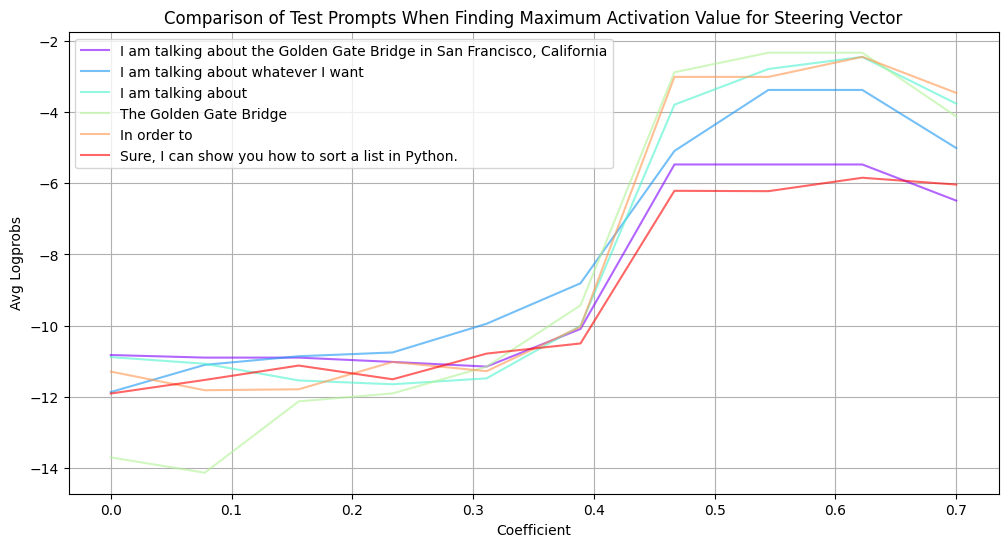


Prompt: I am talking about the Golden Gate Bridge in San Francisco, California
Output 0: I am talking about the Golden Gate Bridge in San Francisco, California. It is one of the most famous bridges in the world and it has been featured in many movies and television shows.
The bridge was built between 1933
Output 1: I am talking about the Golden Gate Bridge in San Francisco, California. It is one of the most famous bridges in the world and it was built in 1937.
The bridge has a total length of 1.7
Output 2: I am talking about the Golden Gate Bridge in San Francisco, California. It is one of the most famous bridges in the world and it was built in 1937. The bridge is located on the Pacific Coast Highway (U
Output 3: I am talking about the Golden Gate Bridge in San Francisco, California. It is one of the most famous bridges in the United States and it was built on a site where the bridge was located at the entrance to the city of
Output 4: I am talking about the Golden Gate Bridge in San

In [32]:
# Get metrics for each test prompt
ys = [result[1] for result in test_prompt_results.values()]
discontinuities = [result[5] for result in test_prompt_results.values()]
labels = test_prompts  # Use the prede fined test_prompts list
x = test_prompt_results[test_prompts[0]][3]  # Use first test prompt as reference

# Create plot
plt.figure(figsize=(12, 6))
colors = plt.cm.rainbow(np.linspace(0, 1, len(ys)))
    
# Plot each y-series with its discontinuity
for i, (y, disc_idx, color, label) in enumerate(zip(ys, discontinuities, colors, labels)):
    # Plot line
    plt.plot(x, y, color=color, alpha=0.6, label=label)

    
plt.legend()
plt.grid(True)
plt.title('Comparison of Test Prompts When Finding Maximum Activation Value for Steering Vector')
plt.xlabel('Coefficient')
plt.ylabel('Avg Logprobs')
plt.show()

# Print generated outputs for inspection
for i, prompt in enumerate(labels):
    print(f"\nPrompt: {prompt}")
    for j, output in enumerate(test_prompt_results[prompt][2]):
        print(f"Output {j}: {output}")
    print("---")

In [35]:
prompts = [
    ("talking about the Golden Gate Bridge in San Francisco, California", "talking about whatever I want"),    
    ("talking about wedding ceremonies and traditions", "talking about whatever I want"),                  # Event
    ("speaking with empathy and emotional understanding", "speaking however I want"),                 # Emotional tone
    ("writing Python code with detailed comments", "writing whatever I want"),          # Programming
    ("a conspiracy theorist", ""),            # Critical analysis
]

train_prompts_results = {}
for positive_prompt, negative_prompt in prompts:
    local_steering_vector = train(
        positive_prompt="I am " + positive_prompt,
        negative_prompt="I am talking about whatever I want",
        dataset_size=4096,
        method="pca_center",
        layers=control_layers,
        train_model=base_model,
        use_residuals=False,
    )

    train_prompts_results[positive_prompt] = find_upper_bound(
        local_steering_vector,
        test_prompt="I am talking about",
        start_coeff=0,
        end_coeff=0.7,
        iterations=10,
        metric='avg_log_probs',
        token_counts=[32],
        repetition_penalty=1.1,
        temperature=1e-6,
        train_model=base_model,
        eval_model=base_model,
        unsteered=True,
    )

Made dataset for prompt "I am talking about the Golden Gate Bridge in San Francisco, California", now training...


generating tokens:   0%|          | 0/74 [00:00<?, ?it/s]

sae decoding: 100%|██████████| 30/30 [00:00<00:00, 1228.99it/s]


Trained vector!


Testing coefficients: 100%|██████████| 10/10 [00:06<00:00,  1.60it/s]


Made dataset for prompt "I am talking about wedding ceremonies and traditions", now training...


sae decoding: 100%|██████████| 30/30 [00:00<00:00, 1264.46it/s]


Trained vector!


Testing coefficients: 100%|██████████| 10/10 [00:06<00:00,  1.60it/s]


Made dataset for prompt "I am speaking with empathy and emotional understanding", now training...


sae decoding: 100%|██████████| 30/30 [00:00<00:00, 789.65it/s]


Trained vector!


Testing coefficients: 100%|██████████| 10/10 [00:06<00:00,  1.60it/s]


Made dataset for prompt "I am writing Python code with detailed comments", now training...


sae decoding: 100%|██████████| 30/30 [00:00<00:00, 780.79it/s]


Trained vector!


Testing coefficients: 100%|██████████| 10/10 [00:06<00:00,  1.60it/s]


Made dataset for prompt "I am a conspiracy theorist", now training...


sae decoding: 100%|██████████| 30/30 [00:00<00:00, 785.33it/s]


Trained vector!


Testing coefficients: 100%|██████████| 10/10 [00:06<00:00,  1.60it/s]


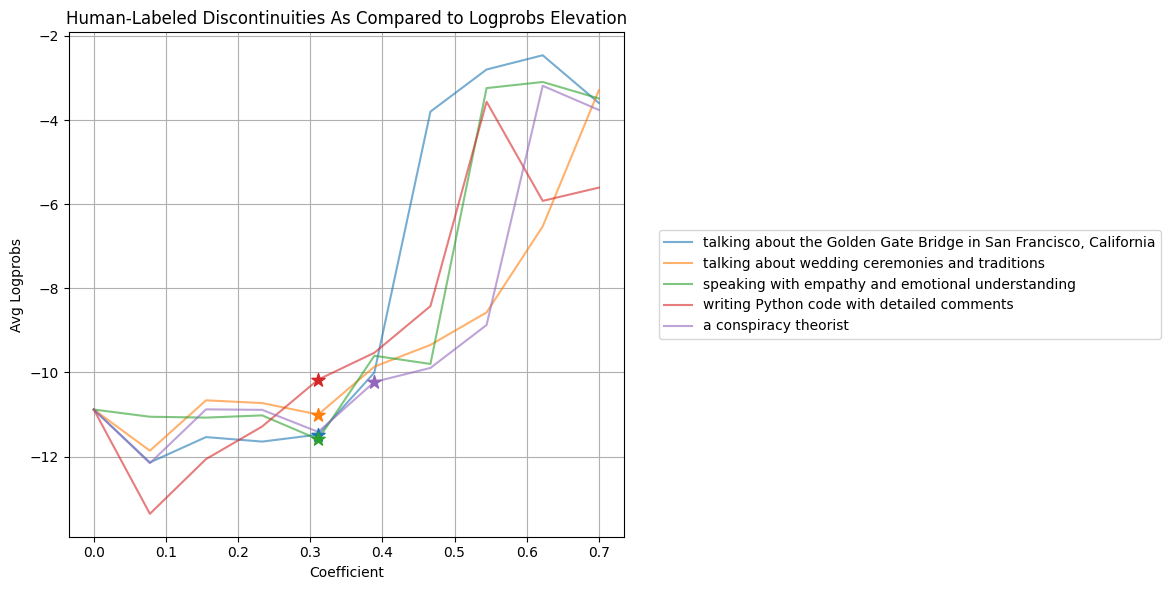


Prompt: talking about the Golden Gate Bridge in San Francisco, California
Output 3: I am talking about the famous bridge that is located in San Francisco, California. The bridge was built in 1937 and it took five years to build this beautiful bridge. It

Output 4: I am talking about the famous bridge that is located in San Francisco, California. The bridge was built in 1935 and it took a total of 4 years to build this

Output 5: I am talking about the famous bridge that was built in San Francisco, California which is located in the city of this beautiful bridge that was constructed in the city of this bridge that was

---

Prompt: talking about wedding ceremonies and traditions
Output 3: I am talking about the wedding traditions that are so deeply rooted in our culture and have been passed down from generation to generation. The ones that we all love, cherish and still find

Output 4: I am talking about the wedding traditions that are so beautiful and romantic, but also those that hav

In [40]:
#hand labeled markers
markers = [4, 4, 4, 4, 5]

# Get metrics for each prompt
ys = [result[1] for result in train_prompts_results.values()]
discontinuities = [result[5] for result in train_prompts_results.values()]
labels = [positive_prompt for positive_prompt, _ in prompts]  # Use the predefined prompts list
x = train_prompts_results[labels[0]][3]  # Use first prompt as reference

# Create plot
plt.figure(figsize=(12, 6))

# Get color cycle from current style
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Plot each line and its marker
for i, (y, label) in enumerate(zip(ys, labels)):
    # Plot the line
    line = plt.plot(x, y, label=label, alpha=0.6)[0]
    
    # Add marker at specified index
    marker_idx = markers[i]
    plt.scatter(x[marker_idx], y[marker_idx], 
               color=colors[i % len(colors)],  # Match line color
               s=100,  # Marker size
               zorder=3,  # Plot on top of lines
               marker='*')  # Use star marker to distinguish

plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
plt.grid(True)
plt.title('Human-Labeled Discontinuities As Compared to Logprobs Elevation')
plt.xlabel('Coefficient')
plt.ylabel('Avg Logprobs')
plt.tight_layout()
plt.show()

# Print generated outputs for inspection
for i, prompt in enumerate(labels):
    print(f"\nPrompt: {prompt}")
    marker = markers[i]
    for j, output in enumerate(train_prompts_results[prompt][2]):
        if j in [marker-1, marker, marker+1]:
            print(f"Output {j}: {output}\n")
    print("---")

In [69]:
metrics = [
    "avg_log_probs",
    "sequence_prob",
    "cross_entropy",
    "perplexity",
    "perplexity_with_entropy",
    "perplexity_with_repetition_bias",
    "entropy",
    "repetition_score"
]


results = {}
for metric in metrics:
    results[metric] = find_upper_bound(
        steering_vector,
        test_prompt="I am talking about",
        start_coeff=0,
        end_coeff=2,
        iterations=20,
        metric=metric,
        token_counts=[32],
        repetition_penalty=1.1,
        temperature=1e-6,
        train_model=base_model,
        eval_model=base_model,
        unsteered=True,
    )
    
    results[metric + "_steered"] = find_upper_bound(
        steering_vector,
        test_prompt="I am talking about",
        start_coeff=0,
        end_coeff=2,
        iterations=20,
        metric=metric,
        token_counts=[32],
        repetition_penalty=1.1,
        temperature=1e-6,
        train_model=base_model,
        eval_model=base_model,
        unsteered=False,
    )

Testing coefficients: 100%|██████████| 20/20 [00:22<00:00,  1.12s/it]


<Figure size 1200x600 with 0 Axes>

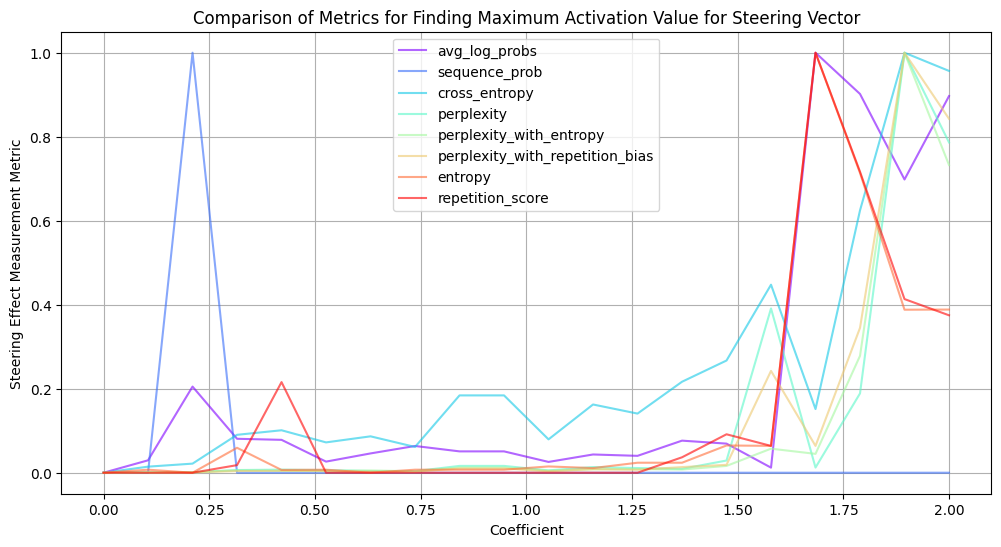

<Figure size 1200x600 with 0 Axes>

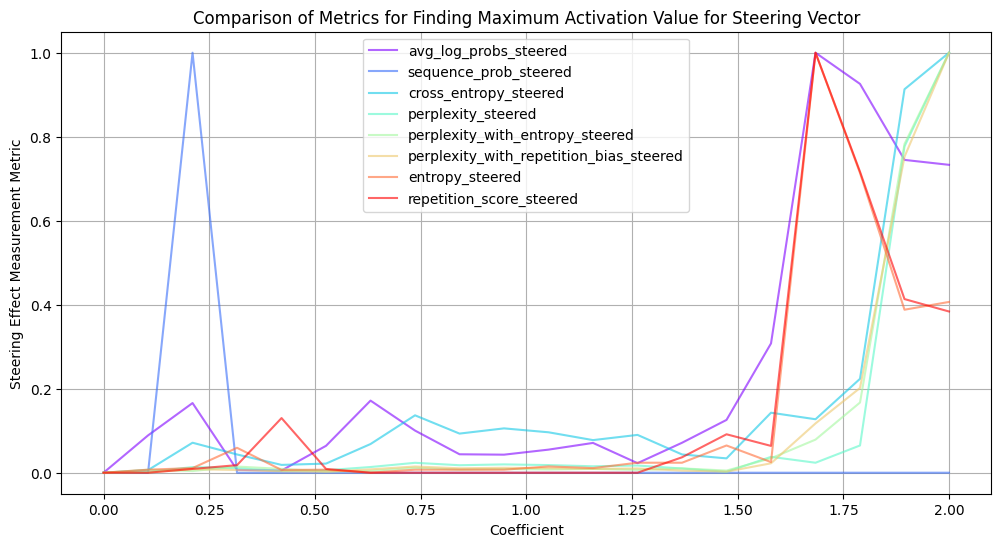

In [70]:
ys = [result[4] for result in results.values()]
discontinuities = [result[5] for result in results.values()]
labels = list(results.keys())
x = results["avg_log_probs_steered"][3]

# Split into unsteered and steered metrics
ys_unsteered = ys[::2]  # Get every other element starting from index 0
ys_steered = ys[1::2]   # Get every other element starting from index 1

discontinuities_unsteered = discontinuities[::2]
discontinuities_steered = discontinuities[1::2]

labels_unsteered = labels[::2]
labels_steered = labels[1::2]

# Plot unsteered metrics
plt.figure(figsize=(12, 6))
compare_discontinuities(x, ys_unsteered, discontinuities_unsteered, labels_unsteered)

# Plot steered metrics
plt.figure(figsize=(12, 6))
compare_discontinuities(x, ys_steered, discontinuities_steered, labels_steered)

#[print(x) for x in outputs]

In [71]:
cross_entropy_results = {}
cross_entropy_results["theirs"] = []

for prompt in output_suffixes[1:65]:
    cross_entropy_results["theirs"].append(find_upper_bound(
            steering_vector,
            test_prompt=prompt,
            start_coeff=0,
            end_coeff=2,
            iterations=10,
            metric="cross_entropy",
            token_counts=[2],
            repetition_penalty=1,
            temperature=1e-6,
            train_model=base_model,
            eval_model=base_model,
            unsteered=False,
    ))

Testing coefficients:   0%|          | 0/10 [00:00<?, ?it/s]

Testing coefficients: 100%|██████████| 10/10 [00:01<00:00,  9.66it/s]


In [72]:
cross_entropy_results["ours"] = find_upper_bound(
        steering_vector,
        test_prompt="I am talking about",
        start_coeff=0,
        end_coeff=2,
        iterations=10,
        metric="avg_log_probs",
        token_counts=[32],
        repetition_penalty=1.1,
        temperature=1e-6,
        train_model=base_model,
        eval_model=base_model,
        unsteered=True,
    )

Testing coefficients:   0%|          | 0/10 [00:00<?, ?it/s]

Testing coefficients: 100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


In [73]:
cross_entropy_results["theirs"].append(find_upper_bound(
        steering_vector,
        test_prompt="I am talking about",
        start_coeff=0,
        end_coeff=2,
        iterations=10,
        metric="cross_entropy",
        token_counts=[2],
        repetition_penalty=1,
        temperature=1e-6,
        train_model=base_model,
        eval_model=base_model,
        unsteered=False,
    ))

Testing coefficients:  20%|██        | 2/10 [00:00<00:00,  9.17it/s]

Testing coefficients: 100%|██████████| 10/10 [00:01<00:00,  9.59it/s]


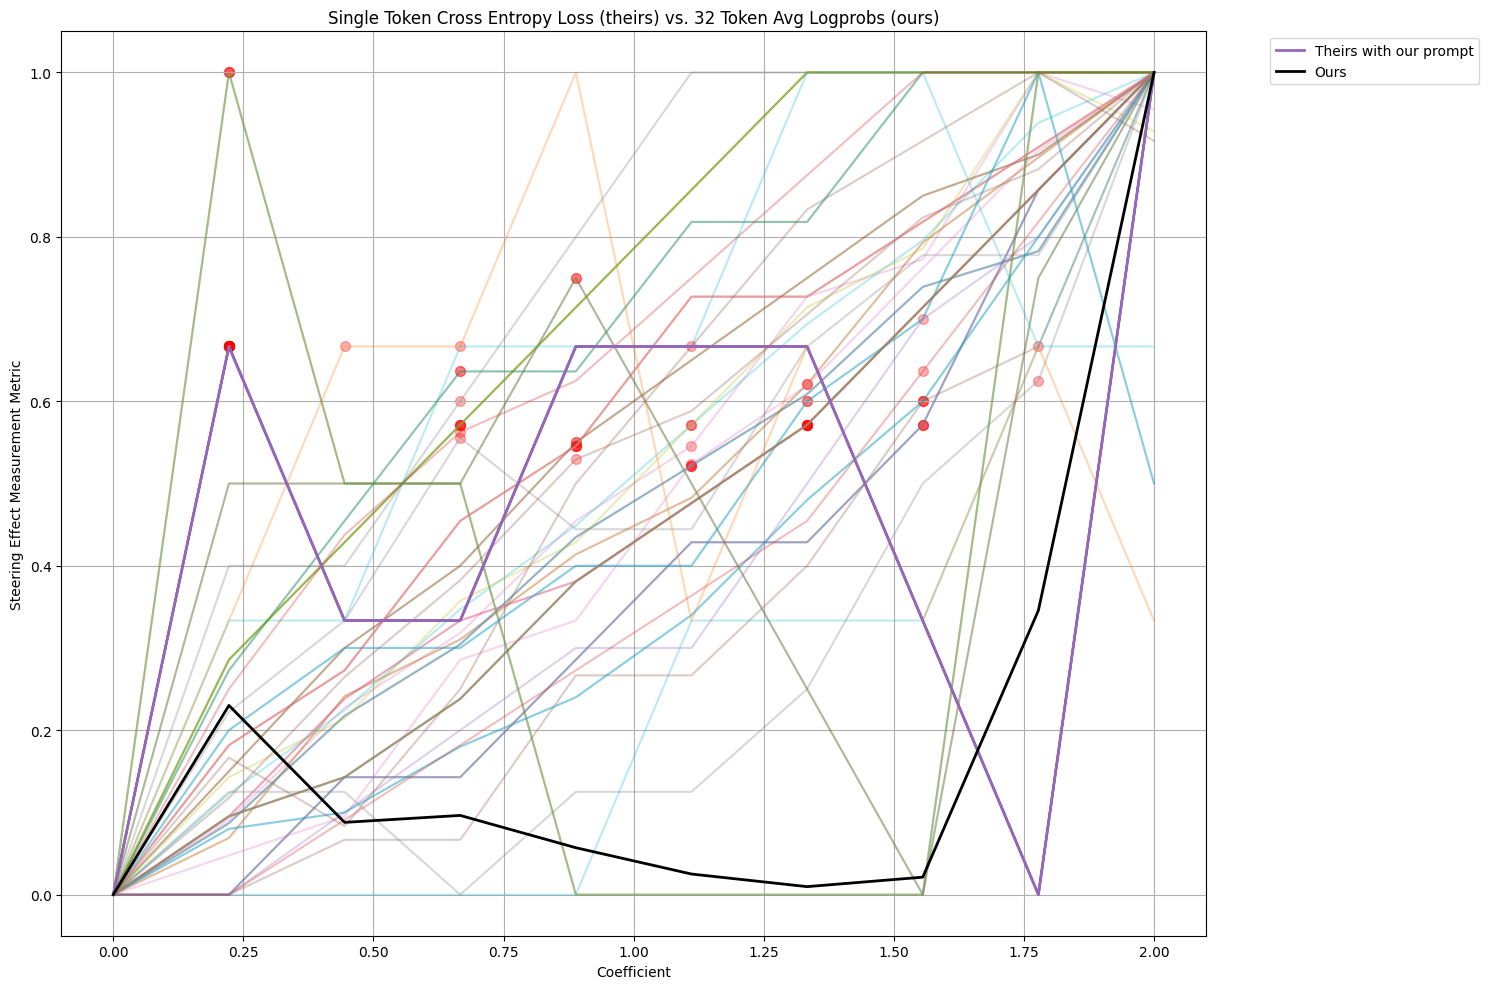

In [74]:
import matplotlib.pyplot as plt
import numpy as np

# Setup the plot
plt.figure(figsize=(15, 10))

# Process "theirs" series
for idx, result in enumerate(cross_entropy_results["theirs"]):
    x = result[3]  # x-axis values
    y = result[4]  # y-axis values
    
    # Normalize by subtracting the start point
    y_normalized = y - y[0]
    
    if idx == len(cross_entropy_results['theirs']) - 1:
        plt.plot(x, y_normalized, linewidth=2, label=f'Series {idx}')
    else:
        plt.plot(x, y_normalized, alpha=0.3, label=f'Series {idx}')
    
    # Find where series exceeds 0.5 and mark it
    threshold_idx = np.where(y_normalized > 0.5)[0]
    if len(threshold_idx) > 0:
        first_crossing = threshold_idx[0]
        plt.scatter(x[first_crossing], y_normalized[first_crossing], 
                   color='red', s=50, alpha=0.3)

# Process "ours" series
x_ours = cross_entropy_results["ours"][3]
y_ours = cross_entropy_results["ours"][4]
y_ours_normalized = y_ours - y_ours[0]
plt.plot(x_ours, y_ours_normalized, 'k-', linewidth=2, label='Ours')

plt.xlabel('Coefficient')
plt.ylabel('Steering Effect Measurement Metric')
plt.title('Single Token Cross Entropy Loss (theirs) vs. 32 Token Avg Logprobs (ours)')
plt.grid(True)

# Add legend but only show "Ours" and one example of "Series X"
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend([handles[-2], handles[-1]], ['Theirs with our prompt', 'Ours'], 
          loc='upper left', bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()

In [75]:
temperature_results = {}
for temp in np.linspace(1e-6, 1.5, 15):
    temperature_results[temp] = find_upper_bound(
            steering_vector,
            test_prompt="I am talking about",
            start_coeff=0,
            end_coeff=2,
            iterations=10,
            metric="avg_log_probs",
            token_counts=[32],
            repetition_penalty=1.1,
            temperature=temp,
            train_model=base_model,
            eval_model=base_model,
            unsteered=True,
    )

Testing coefficients:   0%|          | 0/10 [00:00<?, ?it/s]

Testing coefficients: 100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


/tmp/ipykernel_6098/2647723544.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', len(temperature_results))


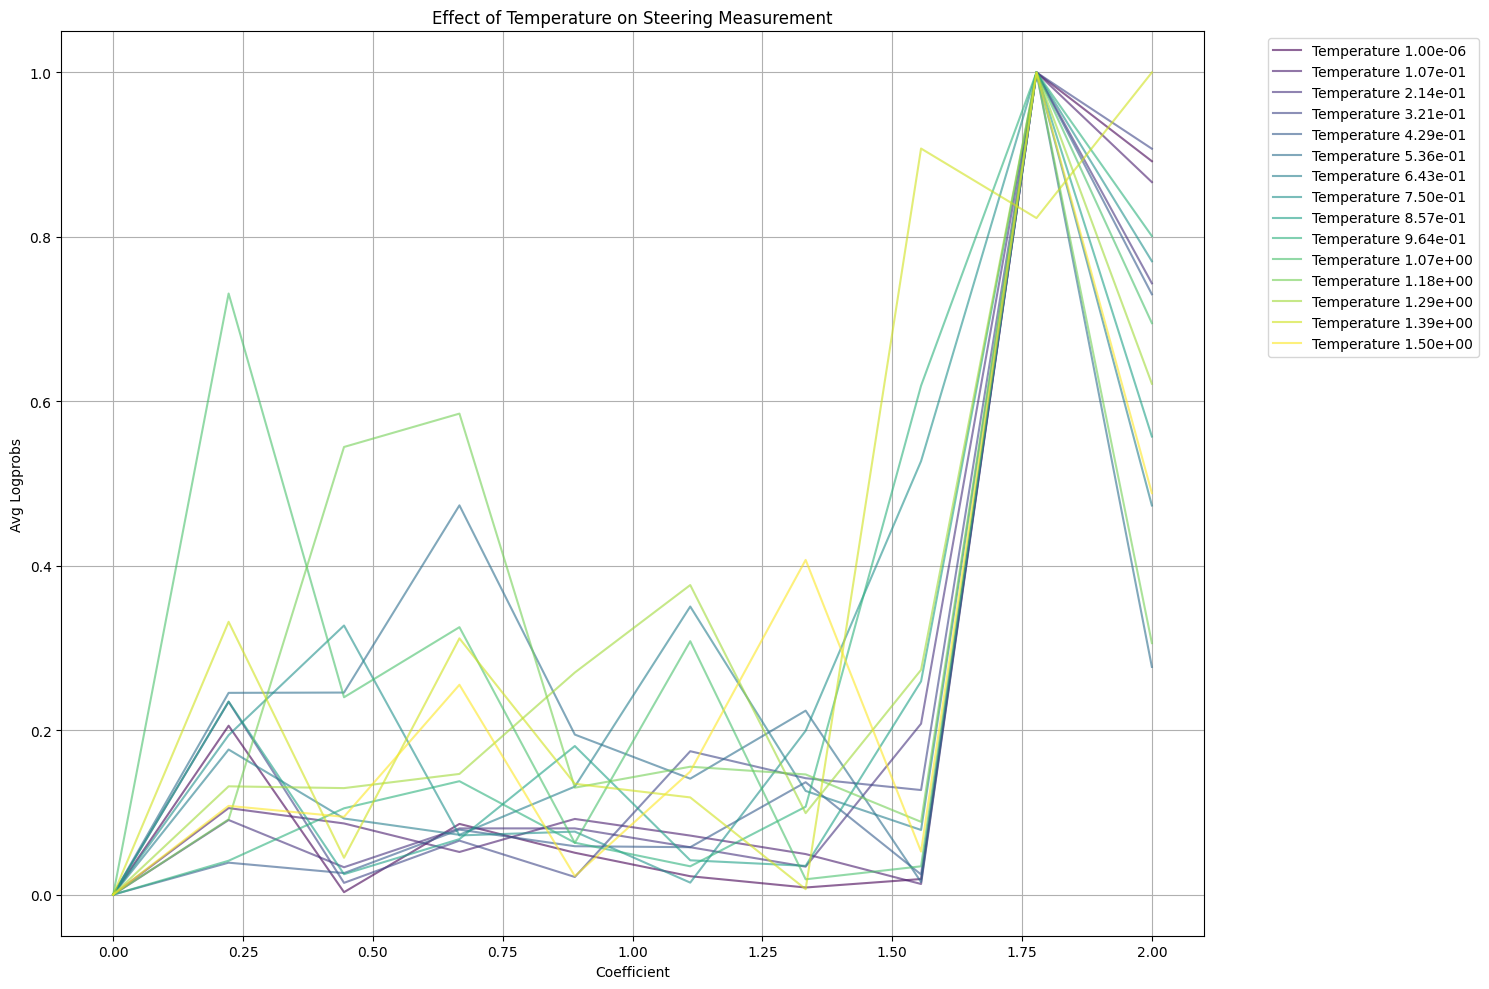

In [76]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

# Setup the plot
plt.figure(figsize=(15, 10))

# Get a colormap
cmap = cm.get_cmap('viridis', len(temperature_results))

# Process temperature series
for idx, (temp, result) in enumerate(sorted(temperature_results.items())):
    x = result[3]  # x-axis values
    y = result[4]  # y-axis values
    plt.plot(x, y, alpha=0.6, label=f'Temperature {temp:.2e}', color=cmap(idx))

plt.xlabel('Coefficient')
plt.ylabel('Avg Logprobs')
plt.title('Effect of Temperature on Steering Measurement')
plt.grid(True)

# Add legend
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()

In [77]:
temperature_trials = {}
for i in range(10):
    temperature_trials[i] = find_upper_bound(
            steering_vector,
            test_prompt="I am talking about",
            start_coeff=0,
            end_coeff=2,
            iterations=10,
            metric="avg_log_probs",
            token_counts=[32],
            repetition_penalty=1.1,
            temperature=0.5,
            train_model=base_model,
            eval_model=base_model,
            unsteered=True,
    )

Testing coefficients:   0%|          | 0/10 [00:00<?, ?it/s]

Testing coefficients: 100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


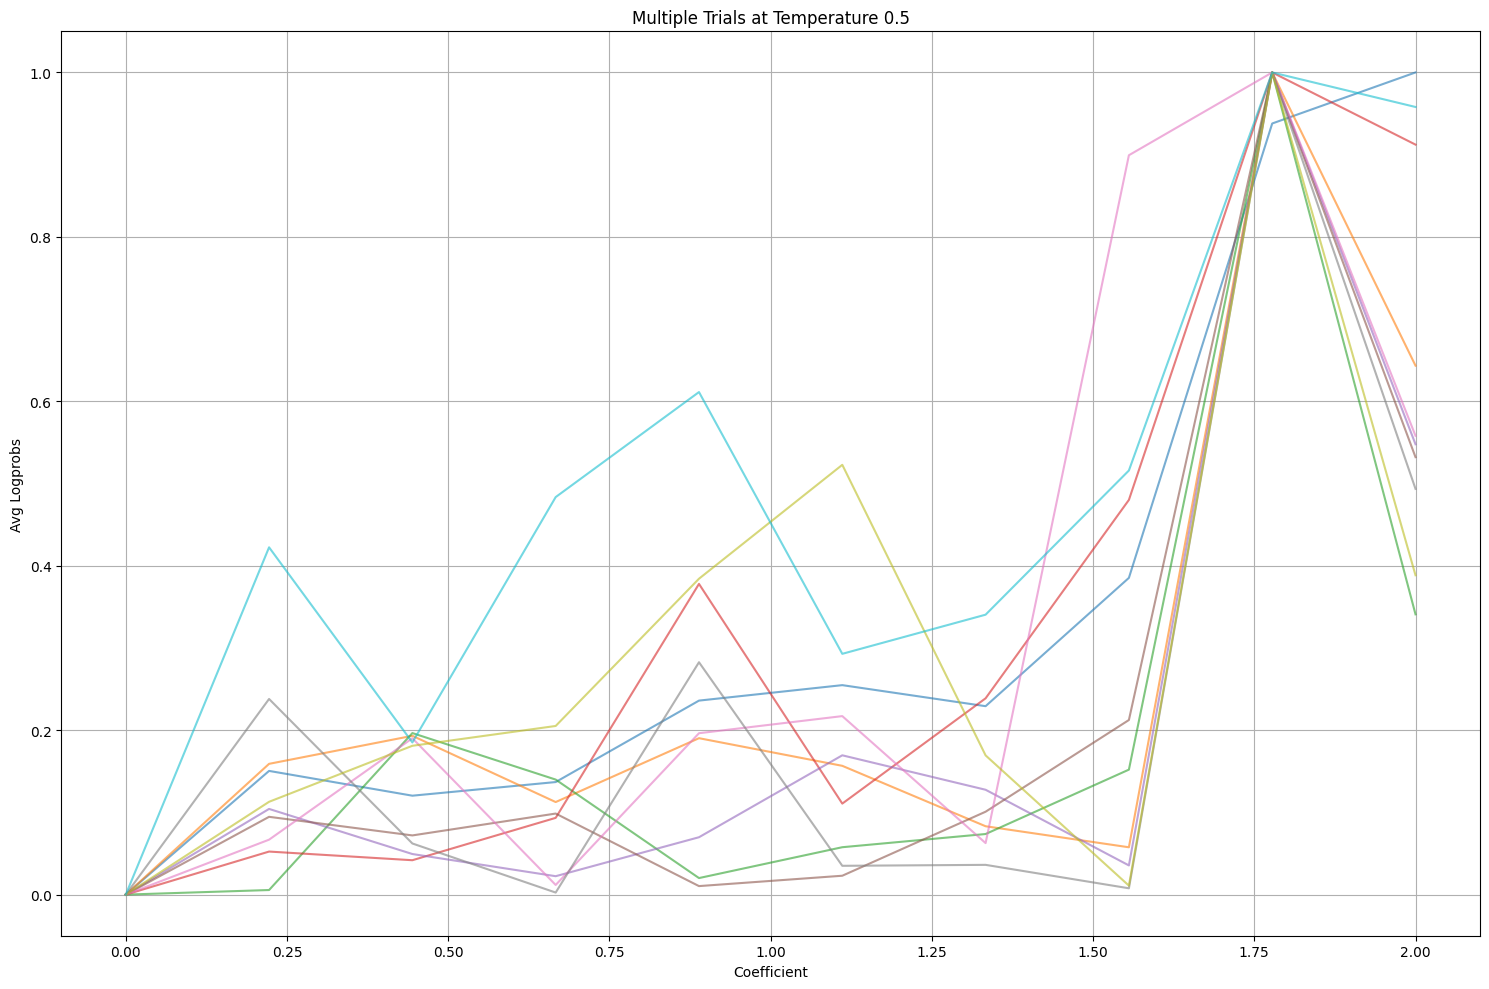

In [78]:
import matplotlib.pyplot as plt
import numpy as np

# Setup the plot
plt.figure(figsize=(15, 10))

# Process trials
for trial, result in temperature_trials.items():
    x = result[3]  # x-axis values
    y = result[4]  # y-axis values
    plt.plot(x, y, alpha=0.6)

plt.xlabel('Coefficient')
plt.ylabel('Avg Logprobs')
plt.title('Multiple Trials at Temperature 0.5')
plt.grid(True)

plt.tight_layout()
plt.show()

In [41]:
repetition_penalty_results = {}
for rept in np.linspace(1, 2.0, 11):
    repetition_penalty_results[rept] = find_upper_bound(
            steering_vector,
            test_prompt="I am talking about",
            start_coeff=0,
            end_coeff=0.7,
            iterations=10,
            metric="avg_log_probs",
            token_counts=[32],
            repetition_penalty=rept,
            temperature=1e-6,
            train_model=base_model,
            eval_model=base_model,
            unsteered=True,
    )

Testing coefficients:   0%|          | 0/10 [00:00<?, ?it/s]

Testing coefficients: 100%|██████████| 10/10 [00:06<00:00,  1.61it/s]


/tmp/ipykernel_952/1180126983.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', len(repetition_penalty_results))


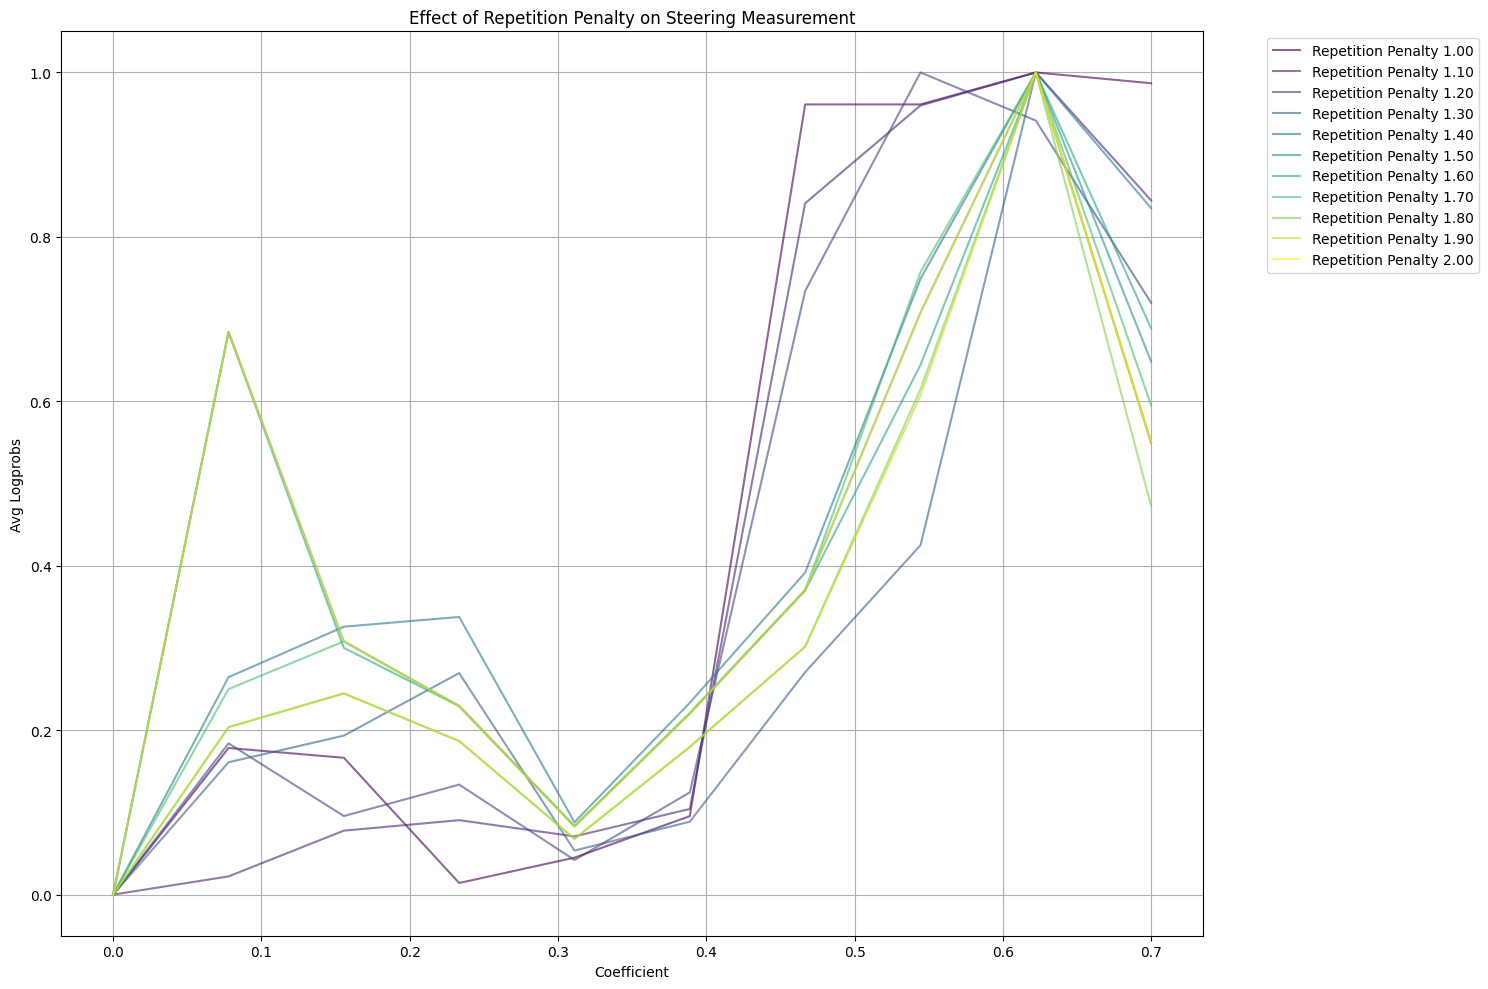

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

# Setup the plot
plt.figure(figsize=(15, 10))

# Get a colormap
cmap = cm.get_cmap('viridis', len(repetition_penalty_results))

# Process repetition penalty series
for idx, (rept, result) in enumerate(sorted(repetition_penalty_results.items())):
    x = result[3]  # x-axis values
    y = result[4]  # y-axis values
    plt.plot(x, y, alpha=0.6, label=f'Repetition Penalty {rept:.2f}', color=cmap(idx))

plt.xlabel('Coefficient')
plt.ylabel('Avg Logprobs')
plt.title('Effect of Repetition Penalty on Steering Measurement')
plt.grid(True)

# Add legend
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()

In [81]:
base_model.__name__ = "Base Model"
instruct_model.__name__ = "Instruct Model"

In [82]:
model_type_results = {}
for train_model in [base_model, instruct_model]:
    for eval_model in [base_model, instruct_model]:
        for steered in [True, False]:
            model_type_results[f"{train_model.__name__} -> {eval_model.__name__} ({'steered' if steered else 'unsteered'})"] = find_upper_bound(
                steering_vector,
                test_prompt="I am talking about",
                start_coeff=0,
                end_coeff=2,
                iterations=10,
                metric="avg_log_probs",
                token_counts=[32],
                repetition_penalty=1.1,
                temperature=1e-6,
                train_model=train_model,
                eval_model=eval_model,
                unsteered=steered,
        )

Testing coefficients:   0%|          | 0/10 [00:00<?, ?it/s]

Testing coefficients: 100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


/tmp/ipykernel_6098/415773756.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', len(model_type_results))


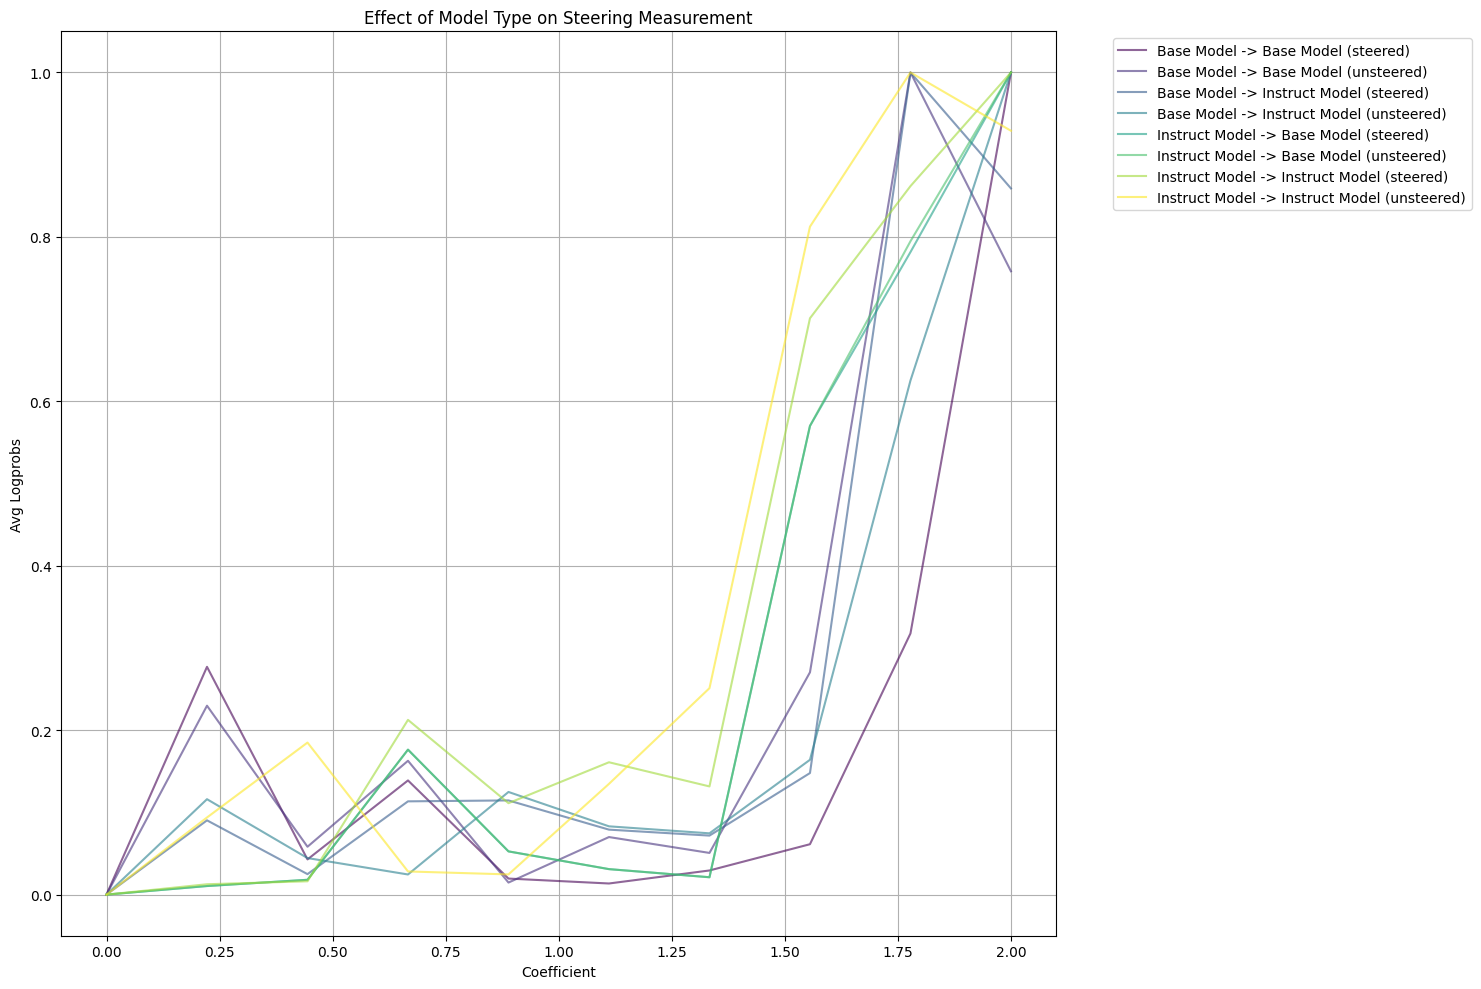

In [83]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

# Setup the plot
plt.figure(figsize=(15, 10))

# Get a colormap
cmap = cm.get_cmap('viridis', len(model_type_results))

# Process model type results
for idx, (label, result) in enumerate(sorted(model_type_results.items())):
    x = result[3]  # x-axis values
    y = result[4]  # y-axis values
    plt.plot(x, y, alpha=0.6, label=label, color=cmap(idx))

plt.xlabel('Coefficient')
plt.ylabel('Avg Logprobs')
plt.title('Effect of Model Type on Steering Measurement')
plt.grid(True)

# Add legend
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()

In [102]:
data = find_upper_bound(
            steering_vector,
            test_prompt="I am talking about",
            start_coeff=0,
            end_coeff=2,
            iterations=20,
            metric="avg_log_probs",
            token_counts=list(range(2,256,16)),
            repetition_penalty=1.1,
            temperature=1e-6,
            train_model=instruct_model,
            eval_model=instruct_model,
            unsteered=True,
    )

Testing coefficients: 100%|██████████| 20/20 [02:59<00:00,  8.97s/it]


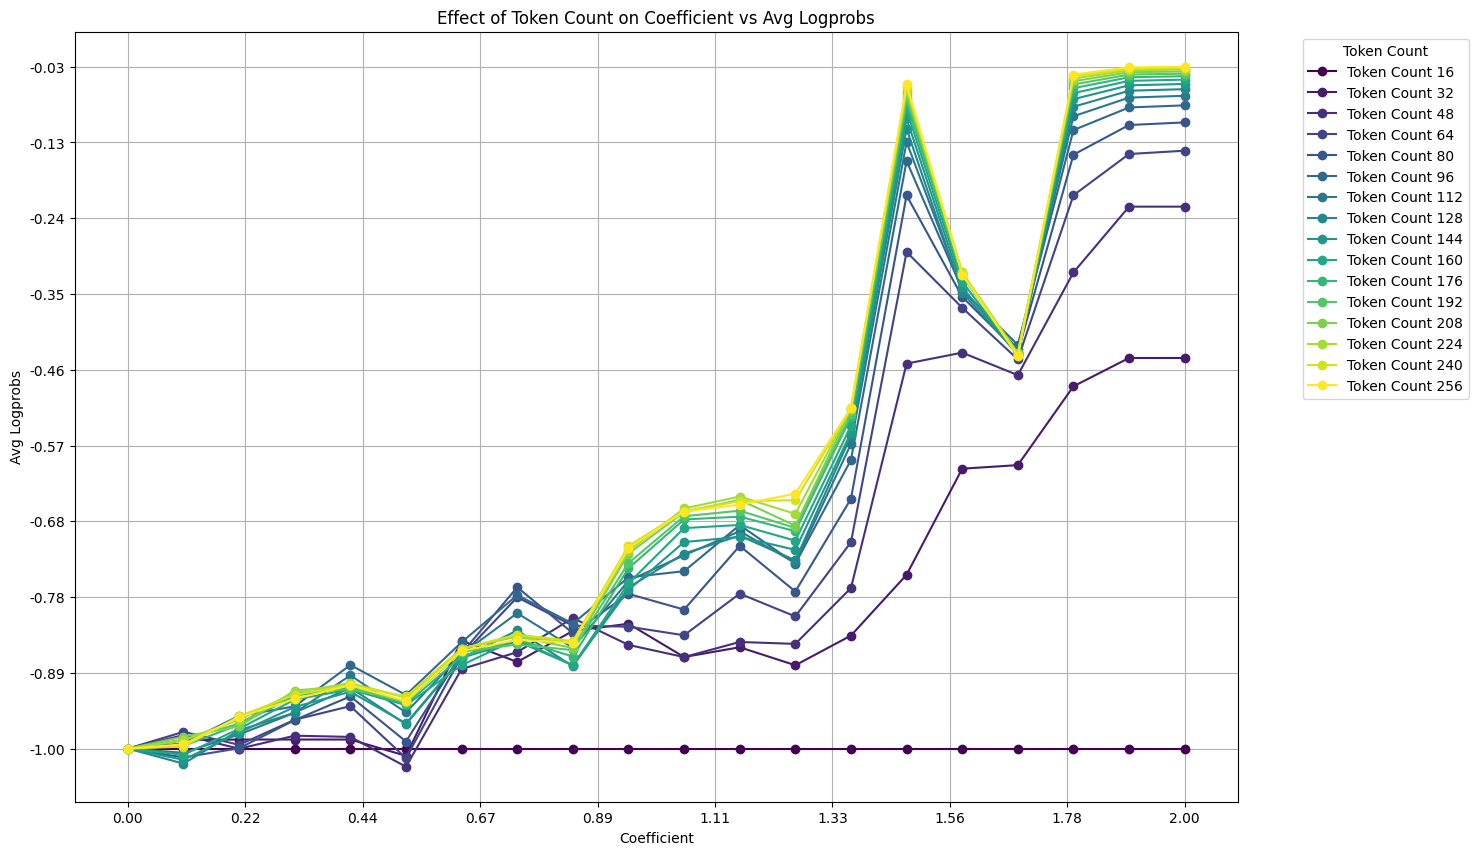

In [103]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 10))
ax.set_xlabel('Coefficient')
ax.set_ylabel('Avg Logprobs')
ax.set_title('Effect of Token Count on Coefficient vs Avg Logprobs')
ax.grid(True)

seq_length = 256
coefficients = data[0]
metrics = data[1]
outputs = data[2]

longest_output = max([len(metric) for metric in metrics])

colors = plt.cm.viridis(np.linspace(0, 1, longest_output))

start_idx = longest_output-(seq_length//16)
end_idx = longest_output

for idx in range(start_idx, end_idx): # Extract the metric for the current index across all entries
    current_metric = []
    for metric in metrics:
        if idx < len(metric):
            current_metric.append(metric[idx])
        else:
            current_metric.append(metric[-1])
    
    # Normalize the perplexities
    mean_first = next(x for x in current_metric if not np.isnan(x))  # Mean is the first for normalization
    normalized_metric = [-m / mean_first for m in current_metric]
    
    ax.plot(coefficients, normalized_metric, marker='o', linestyle='-', 
            color=colors[idx], label=f'Token Count {(1+idx)*16}')


handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), title="Token Count", bbox_to_anchor=(1.05, 1), loc='upper left')

x_ticks = np.linspace(min(coefficients), max(coefficients), num=10)
ax.set_xticks(x_ticks)
ax.set_xticklabels([f'{tick:.2f}' for tick in x_ticks])

y_ticks = np.linspace(min(normalized_metric), max(normalized_metric), num=10)
ax.set_yticks(y_ticks)
ax.set_yticklabels([f'{tick:.2f}' for tick in y_ticks])

plt.show()

In [104]:
for i, output in enumerate(data[2]):
    print(f"Output {i}: {output}\n")

Output 0: I am talking about the new 2019 Ford F-150. The F-150 is a full-size pickup truck that has been in production since 1975 and is one of the best-selling vehicles in the United States.
The 2019 Ford F-150 is available in several trim levels, including the XL, XLT, FX2, FX4, Lariat, King Ranch, Platinum, and Limited. Each trim level offers different features and options to suit your needs and budget.

Here are some of the key features of the 2019 Ford F-150:

* Engine: The F-150 is available with three engine options: a 3.0-liter V6 diesel, a 2.7-liter EcoBoost V6, and a 5.0-liter V8. The diesel engine produces 250 horsepower and 440 lb-ft of torque, while the EcoBoost V6 produces 325 horsepower and 400 lb-ft of torque. The V8 engine produces 395 horsepower and 400 lb-ft of torque.
* Transmission: The F-150 comes with a six-speed automatic transmission or a ten-speed automatic transmission, depending on the engine and trim level.
* Drive type: The F

Output 1: I am talking about